<a href="https://colab.research.google.com/github/BackBencher2424/BA820_Team_14_Project/blob/main/BA820_M3_Integrated_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**BA820 – Project M3**
**Project Title:** *Code Trends, Quantified: Mapping the Programming Language Ecosystem* <br>
**Section and Team Number:** *B1 Team 14* <br>
**Student Name:** *Drishti Chulani, Ahrar Karim, Arshdeep Singh Oberoi, Vishesh Goyal*

In [ ]:
# 0) Setup (Colab-friendly)
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# UMAP is not always installed by default on Colab
try:
    import umap.umap_ as umap
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'umap-learn'])
    import umap.umap_ as umap

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Consistent style (high-contrast + readable)
# One palette for ALL categorical plots (clusters/archetypes/ghost status/etc.)
PALETTE_NAME = "colorblind"                     # vivid + color-safe
PALETTE = sns.color_palette(PALETTE_NAME, 10)   # stable ordering
PRIMARY_COLOR = PALETTE[0]
HEATMAP_CMAP = "mako"                           # blue-toned, higher contrast than pure "Blues"

def blue_palette(n):
    """Return n distinct colors from the global palette (kept for backward compatibility)."""
    n = int(max(3, n))
    return sns.color_palette(PALETTE_NAME, n_colors=n)

sns.set_theme(style="whitegrid", palette=PALETTE)
sns.set_palette(PALETTE)

# Smaller defaults -> cleaner notebook output in Colab
plt.rcParams.update({
    "figure.figsize": (9.2, 5.2),
    "figure.dpi": 120,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "legend.fontsize": 10,
    "legend.title_fontsize": 9,
})

# Keep tables from flooding output
pd.set_option("display.max_rows", 25)
pd.set_option("display.max_columns", 60)
pd.set_option("display.width", 120)

print("Setup complete (consistent palette + compact plot defaults enabled).")


✅ Setup complete (consistent palette + compact plot defaults enabled).


In [ ]:
# 1) Load data (NO fetch)

DATA_PATH = "/content/languages.csv"   # Upload languages.csv to Colab runtime.

df_raw = pd.read_csv(DATA_PATH)
df_raw.columns = [c.strip().lower() for c in df_raw.columns]

# Drop rows where appeared < 1500 (project scope constraint)
_rows_before = len(df_raw)
if "appeared" in df_raw.columns:
    df_raw["appeared"] = pd.to_numeric(df_raw["appeared"], errors="coerce")
    df_raw = df_raw[df_raw["appeared"] >= 1500].copy()
_rows_after = len(df_raw)


In [ ]:
# Load summary (one output)
summary = pd.DataFrame([{
    "data_path": DATA_PATH,
    "rows_before_filter": int(_rows_before),
    "rows_after_filter": int(_rows_after),
    "rows_removed": int(_rows_before - _rows_after)
}])
display(summary)


,data_path,rows_before_filter,rows_after_filter,rows_removed
0,/content/languages.csv,4303,4294,9


In [ ]:
# Preview (one output)
display(df_raw.head(10))


,pldb_id,title,description,type,appeared,creators,website,domain_name,domain_name_registered,reference,isbndb,book_count,semantic_scholar,language_rank,github_repo,github_repo_stars,github_repo_forks,github_repo_updated,github_repo_subscribers,github_repo_created,github_repo_description,github_repo_issues,github_repo_first_commit,github_language,github_language_tm_scope,github_language_type,github_language_ace_mode,github_language_file_extensions,github_language_repos,wikipedia,wikipedia_daily_page_views,wikipedia_backlinks_count,wikipedia_summary,wikipedia_page_id,wikipedia_appeared,wikipedia_created,wikipedia_revision_count,wikipedia_related,features_has_comments,features_has_semantic_indentation,features_has_line_comments,line_comment_token,last_activity,number_of_users,number_of_jobs,origin_community,central_package_repository_count,file_type,is_open_source
0,java,Java,NaN,pl,1995,James Gosling,https://oracle.com/java/,NaN,NaN,NaN,400.0,401,37.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Java,source.java,programming,java,java jav,11529980.0,https://en.wikipedia.org/wiki/Java_(programmin...,5242.0,11543.0,Java is a general-purpose computer programming...,15881.0,1995.0,2001.0,7818.0,javascript pizza ada csharp eiffel mesa modula...,True,False,True,//,2022,5550123,85206,Sun Microsystems,NaN,text,NaN
1,javascript,JavaScript,NaN,pl,1995,Brendan Eich,NaN,NaN,NaN,https://www.w3schools.com/js/js_reserved.asp,349.0,351,48.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,JavaScript,source.js,programming,javascript,js _js bones cjs es es6 frag gs jake javascrip...,16046489.0,https://en.wikipedia.org/wiki/JavaScript,4264.0,8982.0,"JavaScript (), often abbreviated as JS, is a h...",9845.0,1995.0,2001.0,6131.0,java lua scheme perl self c python awk hyperta...,True,False,True,//,2022,5962666,63993,Netscape,NaN,text,NaN
2,c,C,NaN,pl,1972,Dennis Ritchie,NaN,NaN,NaN,http://www.c4learn.com/c-programming/c-keywords/,78.0,78,19.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,source.c,programming,c_cpp,c cats h idc,2160271.0,https://en.wikipedia.org/wiki/C_(programming_l...,6268.0,10585.0,"C (, as in the letter c) is a general-purpose,...",6021.0,2011.0,2001.0,7316.0,cyclone unified-parallel-c split-c cilk b bcpl...,True,False,True,//,2022,3793768,59919,Bell Labs,0.0,text,NaN
3,python,Python,NaN,pl,1991,Guido van Rossum,https://www.python.org/,python.org,1995.0,https://www.programiz.com/python-programming/k...,339.0,342,52.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Python,source.python,programming,python,py cgi fcgi gyp gypi lmi py3 pyde pyi pyp pyt ...,9300725.0,https://en.wikipedia.org/wiki/Python_(programm...,7204.0,6849.0,Python is a widely used high-level programming...,23862.0,1991.0,2001.0,6342.0,jython micropython stackless-python cython abc...,True,True,True,#,2022,2818037,46976,Centrum Wiskunde & Informatica,NaN,text,NaN
4,sql,SQL,NaN,queryLanguage,1974,Donald D. Chamberlin and Raymond F. Boyce,NaN,NaN,NaN,NaN,177.0,182,37.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SQL,source.sql,data,sql,sql cql ddl inc mysql prc tab udf viw,1222.0,https://en.wikipedia.org/wiki/SQL,3084.0,4159.0,SQL ( ( listen) ESS-kew-EL or ( listen) SEE-k...,29004.0,1986.0,2001.0,4153.0,sql-92 datalog linq powershell c sql-psm sqlpl...,True,False,True,--,2022,7179119,219617,IBM,0.0,text,NaN
5,cpp,C++,NaN,pl,1985,Bjarne Stroustrup,http://isocpp.org/,isocpp.org,2012.0,NaN,128.0,128,6.0,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C++,source.c++,programming,c_cpp,cpp c++ cc cp cxx h h++ hh hpp hxx inc inl ino...,2161625.0,https://en.wikipedia.org/wiki/C++,4307.0,10943.0,C++ ( pronounced cee plus plus) is a general-p...,72038.0,1998.0,2001.0,1487.0,ada algol-68 c clu ml simula python csharp cha...,NaN,NaN,NaN,//,2022,4128238,61098,Bell Labs,0.0,text,NaN
6,html,HTML,NaN,textMarkup,1991,Tim Berners-Lee,NaN,NaN,NaN,NaN,111.0,116,7.0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HTML,text.html.basic,markup,html,html hta htm htmlhl inc xht xhtml,12648584.0,https://en.wikipedia.org/wiki/HTML,4897.0,15298.0,Hyperte

## 2) Best-of M2 EDA (Unified)

This section **replaces repeated EDA** across M2 notebooks.  
It keeps the *most grading-relevant* EDA visuals used in M2 so you can compare results consistently.


In [ ]:
# 2.1 Basic schema + dtype overview (one output)
display(df_raw.dtypes.value_counts().to_frame("count"))


,count
object,25
float64,18
int64,6


In [ ]:
# 2.1 Preview (one output)
display(df_raw.head(3))


,pldb_id,title,description,type,appeared,creators,website,domain_name,domain_name_registered,reference,isbndb,book_count,semantic_scholar,language_rank,github_repo,github_repo_stars,github_repo_forks,github_repo_updated,github_repo_subscribers,github_repo_created,github_repo_description,github_repo_issues,github_repo_first_commit,github_language,github_language_tm_scope,github_language_type,github_language_ace_mode,github_language_file_extensions,github_language_repos,wikipedia,wikipedia_daily_page_views,wikipedia_backlinks_count,wikipedia_summary,wikipedia_page_id,wikipedia_appeared,wikipedia_created,wikipedia_revision_count,wikipedia_related,features_has_comments,features_has_semantic_indentation,features_has_line_comments,line_comment_token,last_activity,number_of_users,number_of_jobs,origin_community,central_package_repository_count,file_type,is_open_source
0,java,Java,NaN,pl,1995,James Gosling,https://oracle.com/java/,NaN,NaN,NaN,400.0,401,37.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Java,source.java,programming,java,java jav,11529980.0,https://en.wikipedia.org/wiki/Java_(programmin...,5242.0,11543.0,Java is a general-purpose computer programming...,15881.0,1995.0,2001.0,7818.0,javascript pizza ada csharp eiffel mesa modula...,True,False,True,//,2022,5550123,85206,Sun Microsystems,NaN,text,NaN
1,javascript,JavaScript,NaN,pl,1995,Brendan Eich,NaN,NaN,NaN,https://www.w3schools.com/js/js_reserved.asp,349.0,351,48.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,JavaScript,source.js,programming,javascript,js _js bones cjs es es6 frag gs jake javascrip...,16046489.0,https://en.wikipedia.org/wiki/JavaScript,4264.0,8982.0,"JavaScript (), often abbreviated as JS, is a h...",9845.0,1995.0,2001.0,6131.0,java lua scheme perl self c python awk hyperta...,True,False,True,//,2022,5962666,63993,Netscape,NaN,text,NaN
2,c,C,NaN,pl,1972,Dennis Ritchie,NaN,NaN,NaN,http://www.c4learn.com/c-programming/c-keywords/,78.0,78,19.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,source.c,programming,c_cpp,c cats h idc,2160271.0,https://en.wikipedia.org/wiki/C_(programming_l...,6268.0,10585.0,"C (, as in the letter c) is a general-purpose,...",6021.0,2011.0,2001.0,7316.0,cyclone unified-parallel-c split-c cilk b bcpl...,True,False,True,//,2022,3793768,59919,Bell Labs,0.0,text,NaN


In [ ]:
# 2.2 Missingness summary (one output)
missing = (df_raw.isna().sum()
           .to_frame("missing_count")
           .assign(missing_pct=lambda x: (x["missing_count"] / len(df_raw) * 100).round(2))
           .sort_values("missing_pct", ascending=False))

display(missing.head(15))


,missing_count,missing_pct
github_language_ace_mode,3829,89.17
github_language_tm_scope,3828,89.15
github_language_type,3828,89.15
github_language_file_extensions,3824,89.05
github_language_repos,3824,89.05
line_comment_token,3822,89.01
github_language,3820,88.96
domain_name_registered,3792,88.31
is_open_source,3783,88.10
features_has_line_comments,3756,87.47


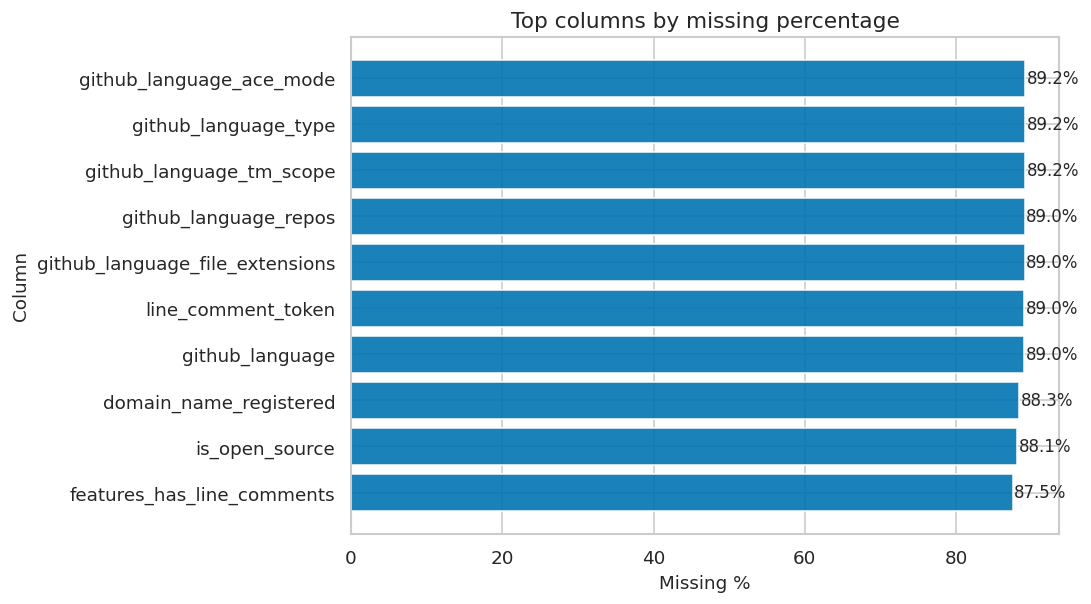

In [ ]:
# 2.2 Top missing columns (bar chart) — one output
top10 = missing[missing["missing_count"] > 0].head(10).sort_values("missing_pct", ascending=True)

plt.figure(figsize=(9.2, 5.2))
plt.barh(top10.index.astype(str), top10["missing_pct"].values, color=PRIMARY_COLOR, alpha=0.9)
plt.title("Top columns by missing percentage")
plt.xlabel("Missing %")
plt.ylabel("Column")

for i_, v in enumerate(top10["missing_pct"].values):
    plt.text(v + 0.2, i_, f"{v:.1f}%", va="center", fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
# 2.3 Duplicate check (M2 Q3 idea)
if "pldb_id" in df_raw.columns:
    dup_count = df_raw["pldb_id"].duplicated().sum()
    print("Duplicate pldb_id rows:", dup_count)
else:
    print("pldb_id column not found — skipping duplicate-id check.")


Duplicate pldb_id rows: 0


In [ ]:
# 2.4 Key distributions + log-scale views (prep; no output)
def safe_numeric(s):
    return pd.to_numeric(s, errors="coerce")

def log10p1(x):
    x = pd.to_numeric(x, errors="coerce")
    return np.log10(x.clip(lower=0) + 1)

core_cols = [
    "github_repo_stars","wikipedia_daily_page_views",
    "number_of_users","number_of_jobs",
    "github_repo_forks","github_repo_subscribers","github_repo_issues",
    "github_language_repos","wikipedia_backlinks_count","wikipedia_revision_count",
    "book_count","central_package_repository_count"
]
available_core = [c for c in core_cols if c in df_raw.columns]

# Show the most important 6 metrics (same lens as M2)
sel = available_core[:6]
_cols_grid = 3
_rows_grid = int(np.ceil(len(sel) / _cols_grid)) if len(sel) else 0


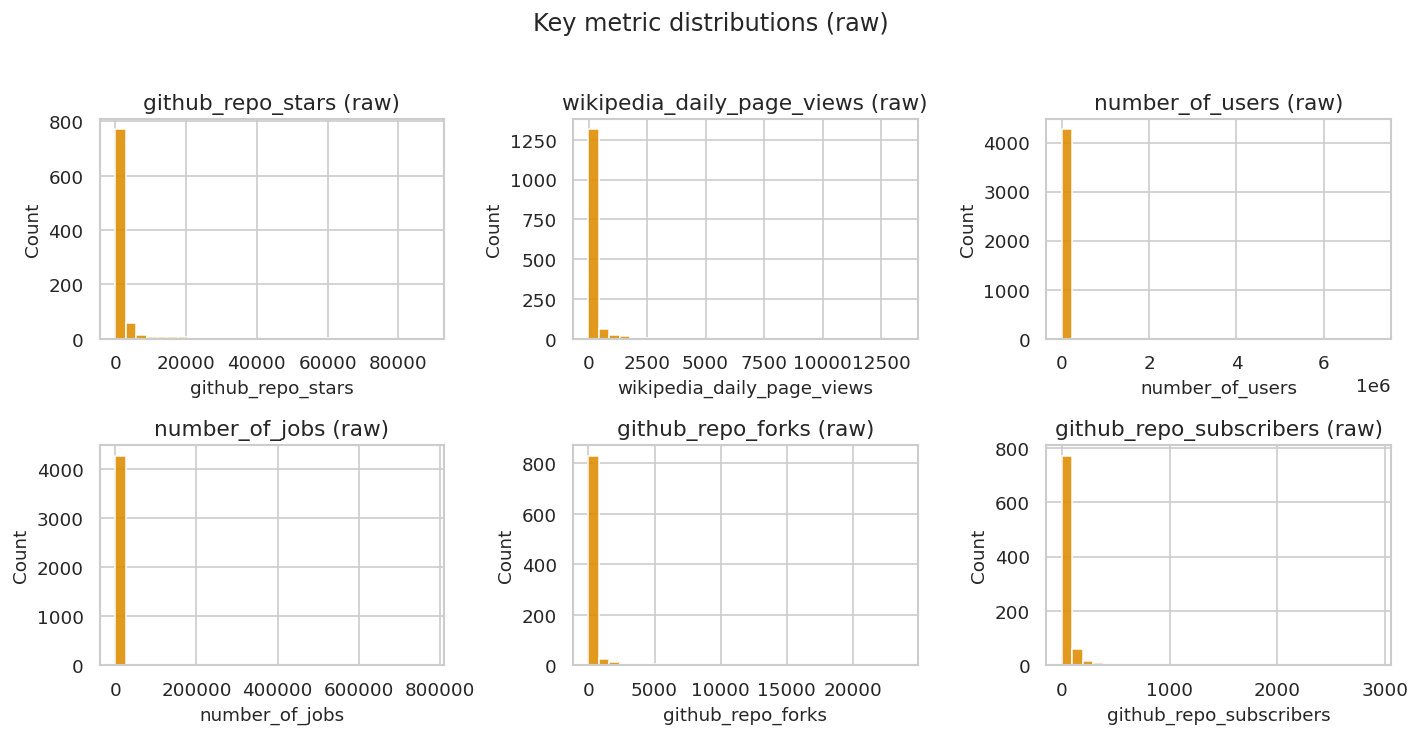

In [ ]:
# 2.4 Key metric distributions (raw) — one output
if len(sel) > 0:
    fig, axes = plt.subplots(_rows_grid, _cols_grid, figsize=(12.0, 6.0))
    axes = np.array(axes).reshape(-1)

    for ax, c in zip(axes, sel):
        x = safe_numeric(df_raw[c]).dropna()
        ax.hist(x, bins=30, color=PALETTE[1], alpha=0.9)
        ax.set_title(f"{c} (raw)")
        ax.set_xlabel(c)
        ax.set_ylabel("Count")

    for ax in axes[len(sel):]:
        ax.axis("off")

    plt.suptitle("Key metric distributions (raw)", y=1.02)
    plt.tight_layout()
    plt.show()
else:
    display(pd.DataFrame([{"note": "No core numeric columns found for distributions."}]))


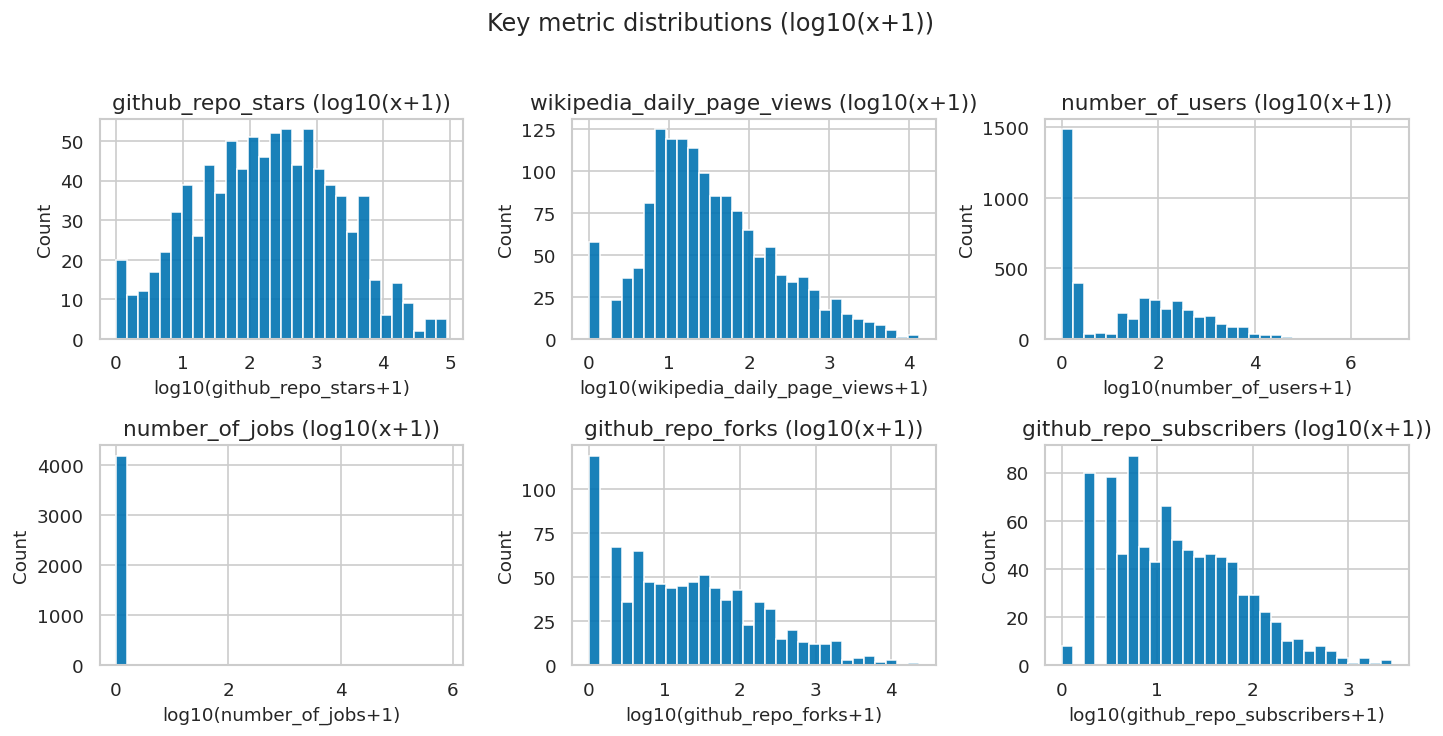

In [ ]:
# 2.4 Key metric distributions (log10(x+1)) — one output
if len(sel) > 0:
    fig, axes = plt.subplots(_rows_grid, _cols_grid, figsize=(12.0, 6.0))
    axes = np.array(axes).reshape(-1)

    for ax, c in zip(axes, sel):
        x = safe_numeric(df_raw[c]).dropna()
        ax.hist(log10p1(x), bins=30, color=PALETTE[0], alpha=0.9)
        ax.set_title(f"{c} (log10(x+1))")
        ax.set_xlabel(f"log10({c}+1)")
        ax.set_ylabel("Count")

    for ax in axes[len(sel):]:
        ax.axis("off")

    plt.suptitle("Key metric distributions (log10(x+1))", y=1.02)
    plt.tight_layout()
    plt.show()


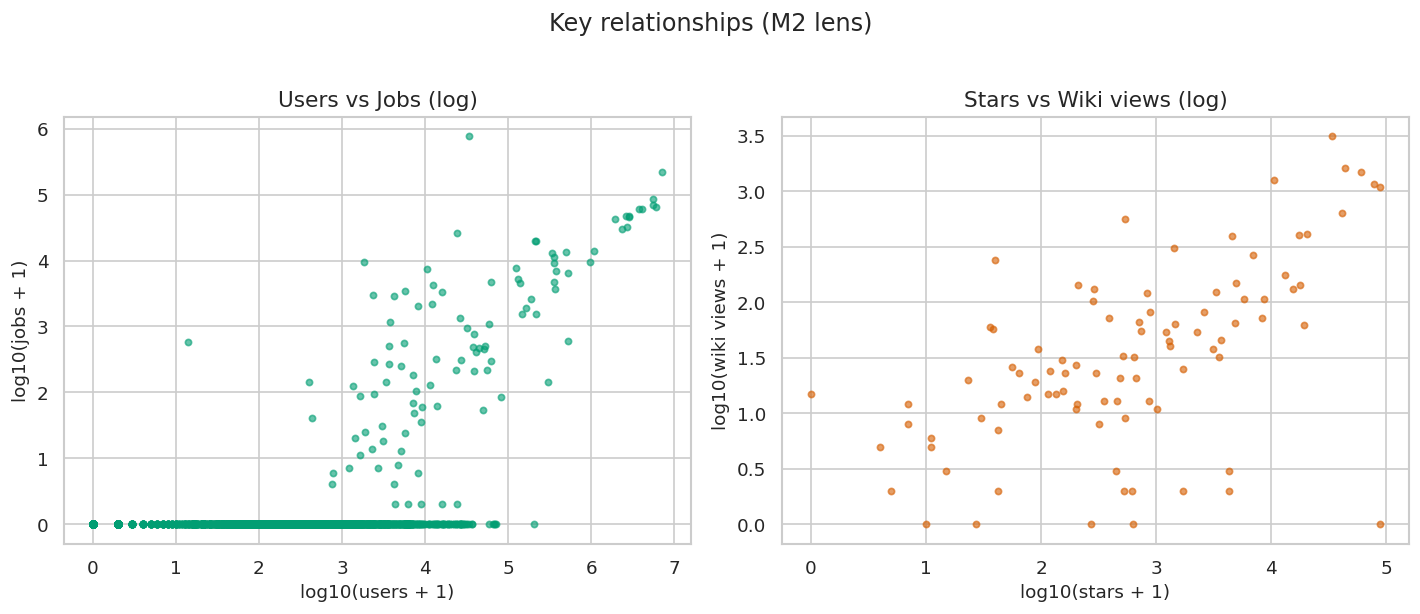

In [ ]:
# 2.4 Key relationships (M2 lens) — one output
fig, ax = plt.subplots(1, 2, figsize=(12.0, 5.0))

if {"number_of_users","number_of_jobs"}.issubset(df_raw.columns):
    tmp = df_raw[["number_of_users","number_of_jobs"]].apply(safe_numeric).dropna()
    ax[0].scatter(log10p1(tmp["number_of_users"]), log10p1(tmp["number_of_jobs"]),
                  s=14, alpha=0.6, color=PALETTE[2])
    ax[0].set_xlabel("log10(users + 1)")
    ax[0].set_ylabel("log10(jobs + 1)")
    ax[0].set_title("Users vs Jobs (log)")

if {"github_repo_stars","wikipedia_daily_page_views"}.issubset(df_raw.columns):
    tmp = df_raw[["github_repo_stars","wikipedia_daily_page_views"]].apply(safe_numeric).dropna()
    ax[1].scatter(log10p1(tmp["github_repo_stars"]), log10p1(tmp["wikipedia_daily_page_views"]),
                  s=14, alpha=0.6, color=PALETTE[3])
    ax[1].set_xlabel("log10(stars + 1)")
    ax[1].set_ylabel("log10(wiki views + 1)")
    ax[1].set_title("Stars vs Wiki views (log)")

plt.suptitle("Key relationships (M2 lens)", y=1.02)
plt.tight_layout()
plt.show()


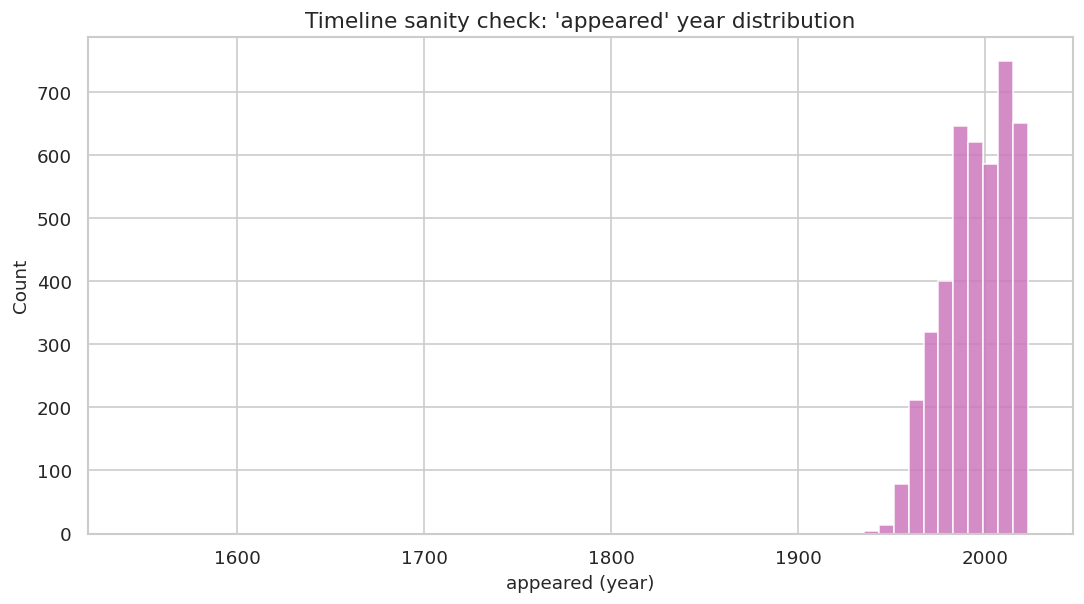

In [ ]:
# 2.5 Timeline sanity check (M2 Q3)
if "appeared" in df_raw.columns:
    appeared = pd.to_numeric(df_raw["appeared"], errors="coerce")
    plt.figure(figsize=(9.2, 5.2))
    plt.hist(appeared.dropna(), bins=60, color=PALETTE[4], alpha=0.85)
    plt.title("Timeline sanity check: 'appeared' year distribution")
    plt.xlabel("appeared (year)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
else:
    print("No 'appeared' column found.")


## 3) Unified Preprocessing (Best-of M2)

Goal: create `df_clean` + analysis-ready views while keeping M2 concepts intact:
- consistent numeric casting  
- consistent log transforms for skewed metrics  
- extension parsing (technical signals)  
- longevity / survival features  


In [ ]:
# 3.1 Start with a clean working copy
df_clean = df_raw.copy()

# 3.2 Numeric casting (common across M2 Q1/Q2/Q3/Q4)
numeric_cols = [
    "appeared","last_activity","language_rank",
    "github_repo_stars","github_repo_forks","github_repo_subscribers","github_repo_issues",
    "github_language_repos",
    "wikipedia_daily_page_views","wikipedia_backlinks_count","wikipedia_revision_count",
    "book_count","central_package_repository_count",
    "number_of_users","number_of_jobs",
    "ecosystem_score"
]
for c in numeric_cols:
    if c in df_clean.columns:
        df_clean[c] = pd.to_numeric(df_clean[c], errors="coerce")

# 3.3 Date casting (Q2/Q3)
date_cols = ["github_repo_updated","github_repo_created","github_repo_first_commit","wikipedia_created"]
for c in date_cols:
    if c in df_clean.columns:
        df_clean[c] = pd.to_datetime(df_clean[c], errors="coerce")

# 3.4 Boolean casting for language feature flags (Q4)
bool_cols = ["features_has_comments","features_has_semantic_indentation","features_has_line_comments"]
for c in bool_cols:
    if c in df_clean.columns:
        df_clean[c] = df_clean[c].astype("boolean")

# 3.5 Treat negative placeholders as missing, then clip counts at 0
if "wikipedia_daily_page_views" in df_clean.columns:
    df_clean.loc[df_clean["wikipedia_daily_page_views"] < 0, "wikipedia_daily_page_views"] = np.nan

count_like = [
    "github_repo_stars","github_repo_forks","github_repo_subscribers","github_repo_issues",
    "github_language_repos",
    "wikipedia_daily_page_views","wikipedia_backlinks_count","wikipedia_revision_count",
    "book_count","central_package_repository_count",
    "number_of_users","number_of_jobs",
]
for c in count_like:
    if c in df_clean.columns:
        df_clean[c] = df_clean[c].clip(lower=0)

# 3.6 Timeline filter (M2 Q3): remove very early "appeared" years for comparability
if "appeared" in df_clean.columns:
    df_clean = df_clean[(df_clean["appeared"].isna()) | (df_clean["appeared"] >= 1500)].copy()

# 3.7 Longevity features (M2 Q4)
REF_YEAR = 2023
if "appeared" in df_clean.columns:
    df_clean["age"] = REF_YEAR - df_clean["appeared"]
if "last_activity" in df_clean.columns:
    df_clean["years_since_last_activity"] = REF_YEAR - df_clean["last_activity"]

if "years_since_last_activity" in df_clean.columns:
    bins = [-np.inf, 5, 15, np.inf]
    labels = ["Active", "Maintained", "Dormant"]
    df_clean["survival_category"] = pd.cut(
        df_clean["years_since_last_activity"], bins=bins, labels=labels, right=False
    )

# 3.8 Ecosystem presence flags (M2 Q4)
for col, newcol in [("domain_name","has_domain"), ("github_repo","has_github"), ("wikipedia","has_wikipedia")]:
    if col in df_clean.columns:
        df_clean[newcol] = df_clean[col].notna().astype(int)

# 3.9 Log features (Q1/Q2/Q3/Q4)
def add_log_features(df_in, col, kind="log1p"):
    if col not in df_in.columns:
        return
    x = pd.to_numeric(df_in[col], errors="coerce").fillna(0).clip(lower=0)
    if kind == "log1p":
        df_in[f"log1p_{col}"] = np.log1p(x)
    elif kind == "log10":
        df_in[f"log10_{col}"] = np.log10(x + 1)

for c in ["number_of_users","number_of_jobs","wikipedia_daily_page_views","github_repo_stars",
          "github_repo_forks","github_repo_subscribers","wikipedia_backlinks_count","wikipedia_revision_count",
          "book_count","central_package_repository_count"]:
    add_log_features(df_clean, c, "log1p")
    add_log_features(df_clean, c, "log10")

df_clean.head(3)


,pldb_id,title,description,type,appeared,creators,website,domain_name,domain_name_registered,reference,isbndb,book_count,semantic_scholar,language_rank,github_repo,github_repo_stars,github_repo_forks,github_repo_updated,github_repo_subscribers,github_repo_created,github_repo_description,github_repo_issues,github_repo_first_commit,github_language,github_language_tm_scope,github_language_type,github_language_ace_mode,github_language_file_extensions,github_language_repos,wikipedia,...,origin_community,central_package_repository_count,file_type,is_open_source,age,years_since_last_activity,survival_category,has_domain,has_github,has_wikipedia,log1p_number_of_users,log10_number_of_users,log1p_number_of_jobs,log10_number_of_jobs,log1p_wikipedia_daily_page_views,log10_wikipedia_daily_page_views,log1p_github_repo_stars,log10_github_repo_stars,log1p_github_repo_forks,log10_github_repo_forks,log1p_github_repo_subscribers,log10_github_repo_subscribers,log1p_wikipedia_backlinks_count,log10_wikipedia_backlinks_count,log1p_wikipedia_revision_count,log10_wikipedia_revision_count,log1p_book_count,log10_book_count,log1p_central_package_repository_count,log10_central_package_repository_count
0,java,Java,NaN,pl,1995,James Gosling,https://oracle.com/java/,NaN,NaN,NaN,400.0,401,37.0,0,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaT,Java,source.java,programming,java,java jav,11529980.0,https://en.wikipedia.org/wiki/Java_(programmin...,...,Sun Microsystems,NaN,text,NaN,28,1,Active,0,0,1,15.529331,6.744303,11.352839,4.930475,8.564649,3.719580,0.0,0.0,0.0,0.0,0.0,0.0,9.353921,4.062356,8.964312,3.893151,5.996452,2.604226,0.0,0.0
1,javascript,JavaScript,NaN,pl,1995,Brendan Eich,NaN,NaN,NaN,https://www.w3schools.com/js/js_reserved.asp,349.0,351,48.0,1,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaT,JavaScript,source.js,programming,javascript,js _js bones cjs es es6 frag gs jake javascrip...,16046489.0,https://en.wikipedia.org/wiki/JavaScript,...,Netscape,NaN,text,NaN,28,1,Active,0,0,1,15.601028,6.775441,11.066545,4.806139,8.358197,3.629919,0.0,0.0,0.0,0.0,0.0,0.0,9.103089,3.953421,8.721276,3.787602,5.863631,2.546543,0.0,0.0
2,c,C,NaN,pl,1972,Dennis Ritchie,NaN,NaN,NaN,http://www.c4learn.com/c-programming/c-keywords/,78.0,78,19.0,2,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaT,C,source.c,programming,c_cpp,c cats h idc,2160271.0,https://en.wikipedia.org/wiki/C_(programming_l...,...,Bell Labs,0.0,text,NaN,51,1,Active,0,0,1,15.148871,6.579071,11.000766,4.777572,8.743372,3.797198,0.0,0.0,0.0,0.0,0.0,0.0,9.267288,4.024732,8.897956,3.864333,4.369448,1.897627,0.0,0.0


### 3.10 Technical signal preprocessing: parse GitHub language extensions (M2 Q1)

Creates:
- `num_extensions_listed`
- top-K extension one-hot columns


In [ ]:
import re

def parse_extensions(ext_str):
    # Parse space-separated extensions into cleaned tokens.
    if pd.isna(ext_str) or not isinstance(ext_str, str):
        return []
    tokens = ext_str.strip().lower().split()
    cleaned=[]
    for t in tokens:
        t=t.strip()
        if not t:
            continue
        t = re.sub(r"[^a-z0-9\.\_\-]+","",t)
        if t:
            cleaned.append(t)
    return cleaned

def sanitize_token(token):
    return "ext_" + re.sub(r"[^a-z0-9]+", "_", token.lower()).strip("_")

if "github_language_file_extensions" in df_clean.columns:
    ext_tokens = df_clean["github_language_file_extensions"].apply(parse_extensions)
    df_clean["num_extensions_listed"] = ext_tokens.apply(lambda x: len(set(x)))

    K = 30
    all_ext = ext_tokens.explode()
    top_ext = all_ext.value_counts().head(K).index.tolist()
    for e in top_ext:
        df_clean[sanitize_token(e)] = ext_tokens.apply(lambda xs: int(e in set(xs)))

    print(f"Extension features added: num_extensions_listed + {len(top_ext)} dummies")
else:
    print("github_language_file_extensions not found — skipping extension feature engineering.")


✅ Extension features added: num_extensions_listed + 30 dummies


## 4) Analysis-ready views (shared inputs for Q1–Q4 + M3)

In [ ]:
# 4.1 Build analysis-ready views from df_clean (required by Q1–Q4 + M3)
# NOTE: these are *views* (subsets) — df_clean remains the single source of truth.

# Community/adoption view (numeric)
comm_candidates = [
    'log10_wikipedia_daily_page_views','log10_github_repo_stars','log10_number_of_users','log10_number_of_jobs',
    'log10_github_repo_forks','log10_github_repo_subscribers',
    'log10_wikipedia_backlinks_count','log10_wikipedia_revision_count',
    'log10_book_count','log10_central_package_repository_count',
    'language_rank','ecosystem_score'
]
comm_cols = [c for c in comm_candidates if c in df_clean.columns]
df_comm = df_clean[comm_cols].copy() if len(comm_cols) else pd.DataFrame(index=df_clean.index)

# Technical/extensions view (numeric)
tech_cols = []
if 'num_extensions_listed' in df_clean.columns:
    tech_cols.append('num_extensions_listed')
tech_cols += [c for c in df_clean.columns if c.startswith('ext_')]
df_tech = df_clean[tech_cols].copy() if len(tech_cols) else pd.DataFrame(index=df_clean.index)

# Hype vs utility view (full row context; numeric subsets are selected per question)
df_hype = df_clean.copy()

# Longevity/ecosystem view (full row context; Q4 does encoding inside its section)
df_long = df_clean.copy()


In [ ]:
# Feature-view tables created for Q1–Q4 (one output)
shapes = pd.DataFrame([
    {"view": "df_comm (community/adoption)", "rows": df_comm.shape[0], "cols": df_comm.shape[1]},
    {"view": "df_tech (technical/extensions)", "rows": df_tech.shape[0], "cols": df_tech.shape[1]},
    {"view": "df_hype (hype vs utility)", "rows": df_hype.shape[0], "cols": df_hype.shape[1]},
    {"view": "df_long (longevity/ecosystem)", "rows": df_long.shape[0], "cols": df_long.shape[1]},
])
display(shapes)


,view,rows,cols
0,df_comm (community/adoption),4294,11
1,df_tech (technical/extensions),4294,31
2,df_hype (hype vs utility),4294,106
3,df_long (longevity/ecosystem),4294,106


## 5) Shared utilities (silhouette sweep, PCA/UMAP plots)

In [ ]:
def build_numeric_pipeline():
    return Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ])

pipe = build_numeric_pipeline()

def silhouette_sweep_kmeans(X, k_list):
    rows=[]
    for k in k_list:
        model = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
        labels = model.fit_predict(X)
        s = silhouette_score(X, labels) if len(set(labels)) > 1 else np.nan
        rows.append({"k":k, "silhouette":s, "inertia":model.inertia_})
    return pd.DataFrame(rows)

def plot_elbow_sil(df_scores, title_prefix=""):
    """Compact elbow + silhouette plot (avoids huge outputs)."""
    fig, ax = plt.subplots(1, 2, figsize=(12.0, 5.0))
    ax[0].plot(df_scores["k"], df_scores["inertia"], marker="o")
    ax[0].set_title(f"{title_prefix} Elbow (Inertia)")
    ax[0].set_xlabel("k")
    ax[0].set_ylabel("Inertia (SSE)")

    ax[1].plot(df_scores["k"], df_scores["silhouette"], marker="o")
    ax[1].set_title(f"{title_prefix} Silhouette vs k")
    ax[1].set_xlabel("k")
    ax[1].set_ylabel("Silhouette")
    plt.tight_layout(rect=[0, 0, 0.82, 1])
    plt.show()

def _cluster_color_map(labels):
    uniq = sorted(pd.unique(pd.Series(labels).dropna()))
    color_map = {u: PALETTE[i % len(PALETTE)] for i, u in enumerate(uniq)}
    return uniq, color_map

def scatter_clusters(Z, labels, title, xlabel, ylabel, legend_title="Cluster"):
    labels = np.asarray(labels)
    uniq, cmap = _cluster_color_map(labels)

    plt.figure(figsize=(9.2, 5.2))
    for u in uniq:
        m = labels == u
        plt.scatter(Z[m,0], Z[m,1], s=14, alpha=0.65, color=cmap[u], label=str(u))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(title=legend_title, bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout(rect=[0, 0, 0.82, 1])
    plt.show()

def pca_scatter(X, labels, title="PCA scatter"):
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    Z = pca.fit_transform(X)
    scatter_clusters(Z, labels, title=title, xlabel="PC1", ylabel="PC2", legend_title="Cluster")
    return pca, Z

def umap_scatter(X, labels, title="UMAP scatter", n_neighbors=15, min_dist=0.1):
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=RANDOM_STATE)
    Z = reducer.fit_transform(X)
    scatter_clusters(Z, labels, title=title, xlabel="UMAP-1", ylabel="UMAP-2", legend_title="Cluster")
    return reducer, Z

k_list = list(range(2, 11))


## 6) Reproduce M2 Q1 (Vishesh): Technical vs Community clustering

,k,silhouette,inertia
0,2,0.979152,120436.413291
1,3,0.975363,114161.155899
2,4,0.973400,108604.924570
3,5,0.964622,103761.763060
4,6,0.967590,98907.466062
5,7,0.968458,93818.312131
6,8,0.967630,89087.622513
7,9,0.963770,85685.662242
8,10,0.971138,80201.992120


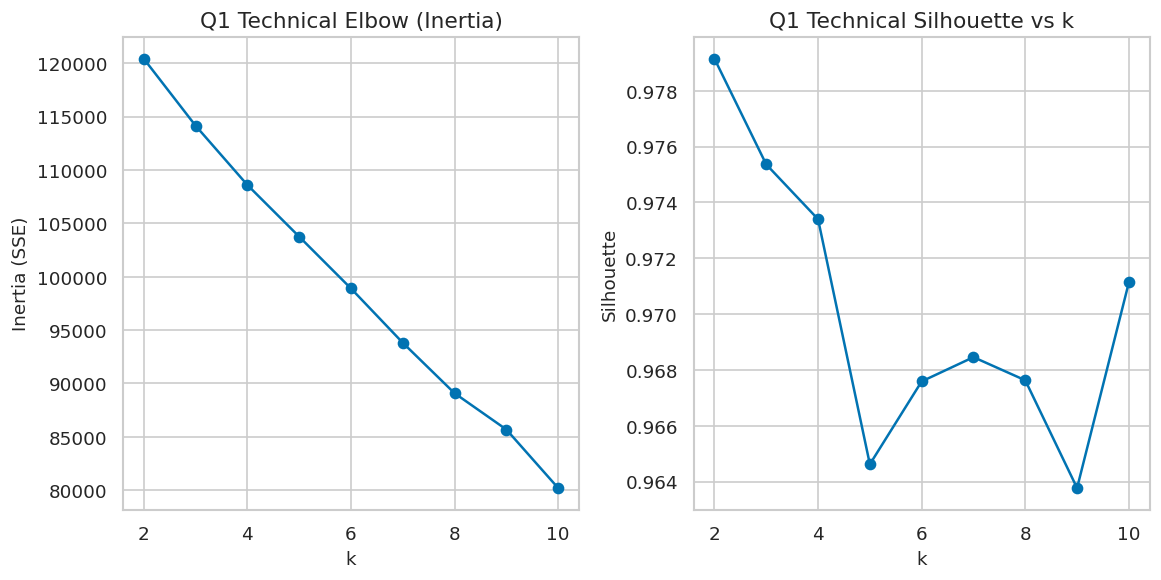

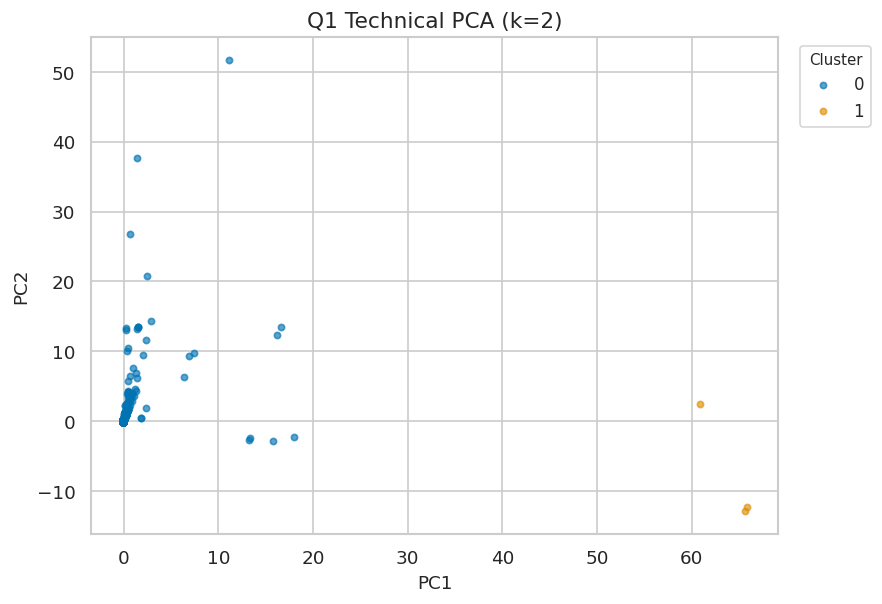

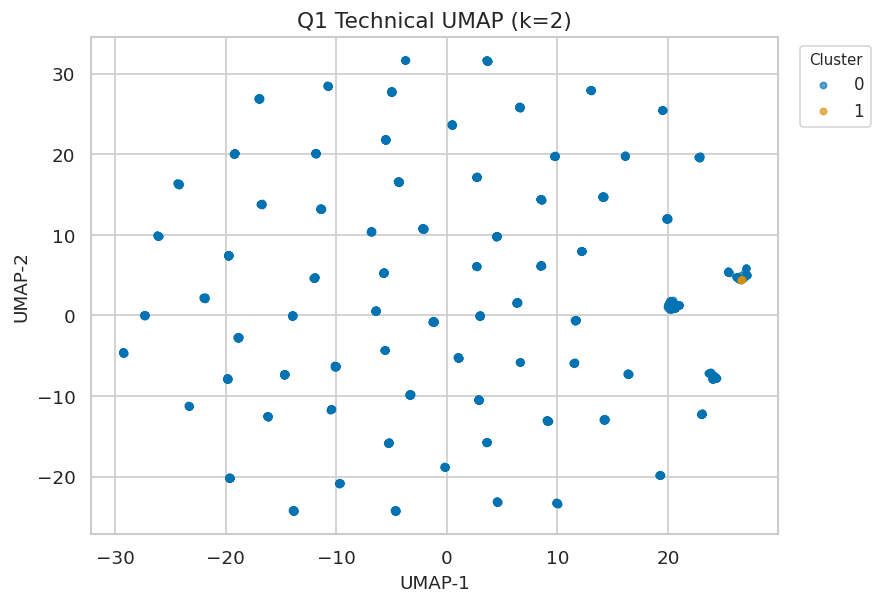

(UMAP(n_jobs=1, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}),
 array([[ 24.314459 ,  -7.707818 ],
        [ 26.518337 ,   4.5858555],
        [ 26.603794 ,   4.999509 ],
        ...,
        [  6.5736876,  25.836483 ],
        [ -9.686465 , -20.746014 ],
        [  6.518167 ,  25.880758 ]], dtype=float32))

In [ ]:
# 6.1 Q1 Technical clustering (extensions)
tech_num = [c for c in df_tech.columns if c not in ["appeared","last_activity"]]
X_tech = df_tech[tech_num].copy()
X_tech_prep = pipe.fit_transform(X_tech)

scores_tech = silhouette_sweep_kmeans(X_tech_prep, k_list)
display(scores_tech)
plot_elbow_sil(scores_tech, title_prefix="Q1 Technical")

best_k_tech = int(scores_tech.sort_values("silhouette", ascending=False).iloc[0]["k"])
labels_tech = KMeans(n_clusters=best_k_tech, random_state=RANDOM_STATE, n_init=10).fit_predict(X_tech_prep)

pca_scatter(X_tech_prep, labels_tech, title=f"Q1 Technical PCA (k={best_k_tech})")
umap_scatter(X_tech_prep, labels_tech, title=f"Q1 Technical UMAP (k={best_k_tech})")


,k,silhouette,inertia
0,2,0.456258,29270.378241
1,3,0.550480,17268.396005
2,4,0.569632,11685.064216
3,5,0.552587,9921.017821
4,6,0.527874,8532.371781
5,7,0.454646,7577.197797
6,8,0.438806,6809.961040
7,9,0.444805,6268.136041
8,10,0.455762,5588.391032


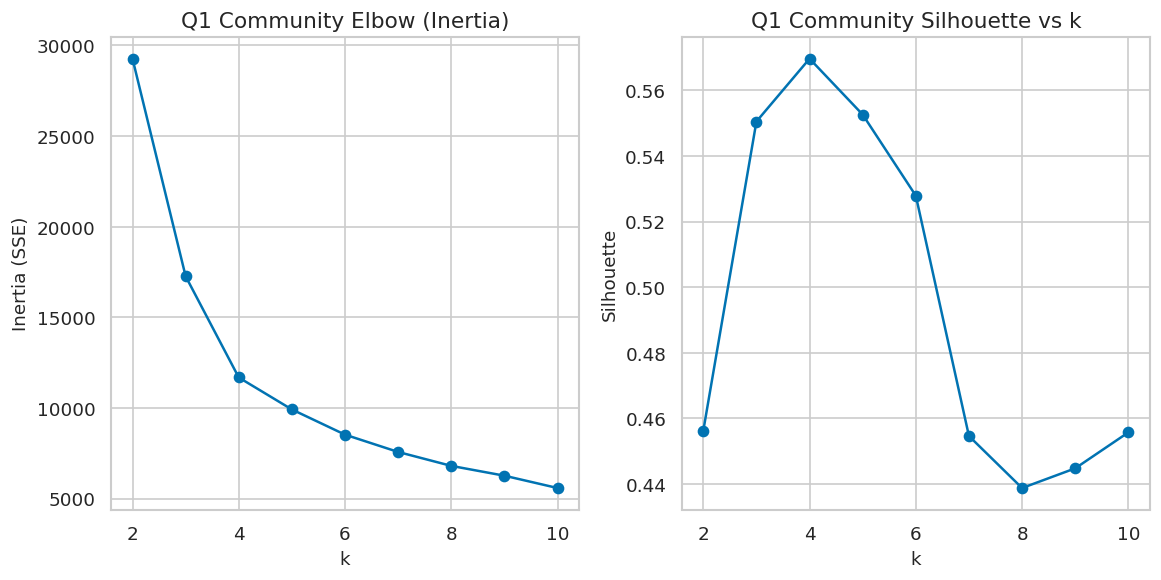

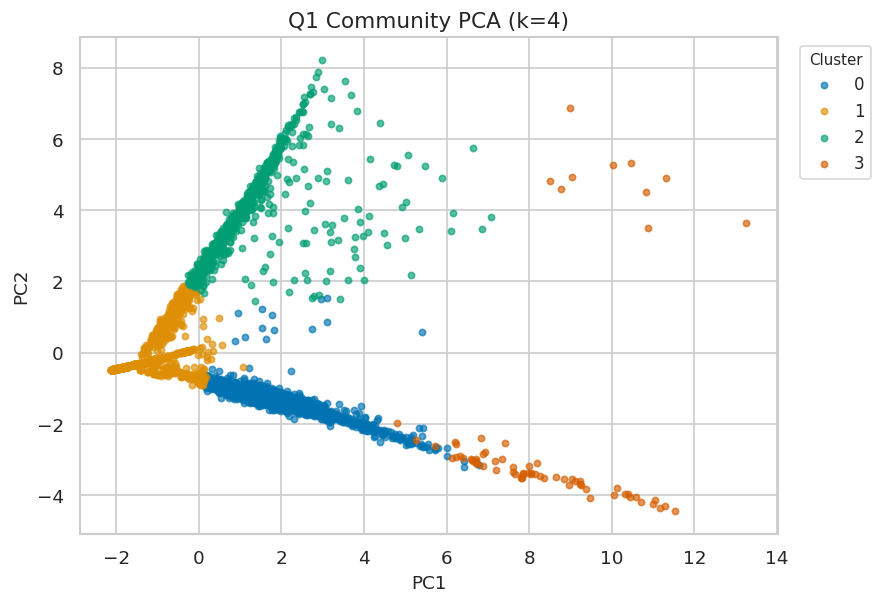

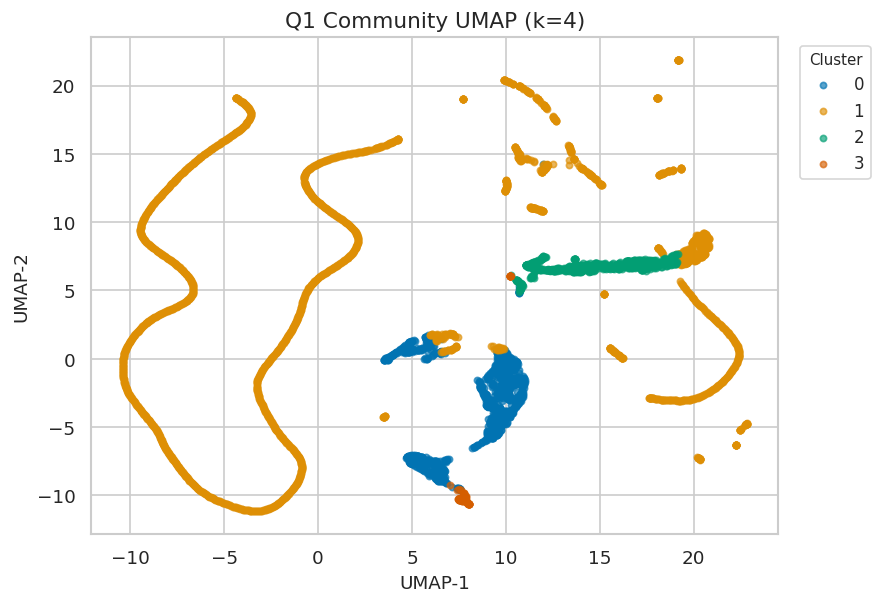

(UMAP(n_jobs=1, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}),
 array([[  8.02385 , -10.609653],
        [  8.009708, -10.596806],
        [  8.007873, -10.573275],
        ...,
        [ -9.445057,   9.642939],
        [ -9.442566,   9.674106],
        [ -9.44029 ,   9.704102]], dtype=float32))

In [ ]:
# 6.2 Q1 Community clustering
X_comm = df_comm.copy()
X_comm_prep = pipe.fit_transform(X_comm)

scores_comm = silhouette_sweep_kmeans(X_comm_prep, k_list)
display(scores_comm)
plot_elbow_sil(scores_comm, title_prefix="Q1 Community")

best_k_comm = int(scores_comm.sort_values("silhouette", ascending=False).iloc[0]["k"])
labels_comm = KMeans(n_clusters=best_k_comm, random_state=RANDOM_STATE, n_init=10).fit_predict(X_comm_prep)

pca_scatter(X_comm_prep, labels_comm, title=f"Q1 Community PCA (k={best_k_comm})")
umap_scatter(X_comm_prep, labels_comm, title=f"Q1 Community UMAP (k={best_k_comm})")


## 7) Reproduce M2 Q2 (Drishti): Hype vs Utility archetypes

In [ ]:
# Q2 (M2 Drishti): Hype vs Utility archetypes
q2_features = ["log10_github_repo_stars","log10_wikipedia_daily_page_views","log10_number_of_users","log10_number_of_jobs"]
q2_features = [c for c in q2_features if c in df_hype.columns]
assert len(q2_features) >= 3, f"Not enough Q2 features found. Available: {df_hype.columns.tolist()}"

X_q2 = df_hype[q2_features].copy()
X_q2_prep = pipe.fit_transform(X_q2)

# Model selection metrics (kept from M2; visuals shown in next cells)
scores_q2 = silhouette_sweep_kmeans(X_q2_prep, k_list)


In [ ]:
# Q2: silhouette + inertia table (one output)
display(scores_q2)


,k,silhouette,inertia
0,2,0.504201,11377.828861
1,3,0.539619,7070.022438
2,4,0.683808,3064.455701
3,5,0.667016,2355.249661
4,6,0.671601,1880.910220
5,7,0.671954,1561.765128
6,8,0.666285,1325.249935
7,9,0.665613,1155.389082
8,10,0.667546,1010.499341


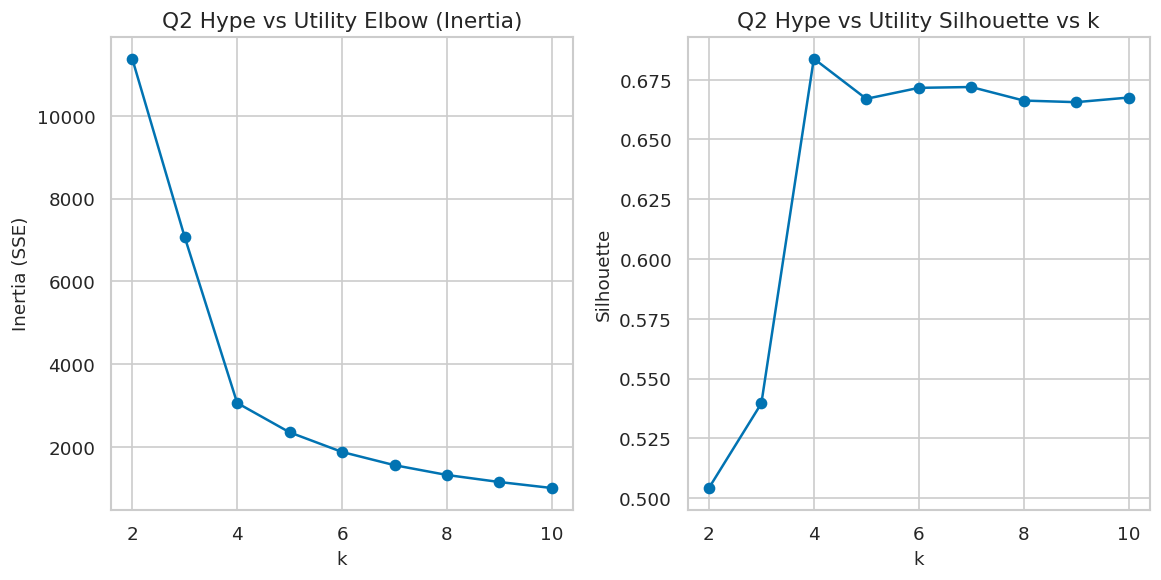

In [ ]:
# Q2: elbow + silhouette plot (one output)
plot_elbow_sil(scores_q2, title_prefix="Q2 Hype vs Utility")


In [ ]:
# Q2: archetype assignment (k=4) + counts (one output)
k_q2 = 4  # preserve M2 baseline choice
df_hype["q2_cluster"] = KMeans(n_clusters=k_q2, random_state=RANDOM_STATE, n_init=10).fit_predict(X_q2_prep)

q2_counts = df_hype["q2_cluster"].value_counts().sort_index().to_frame("count")
display(q2_counts)


,count
q2_cluster,
0,1180
1,2357
2,82
3,675


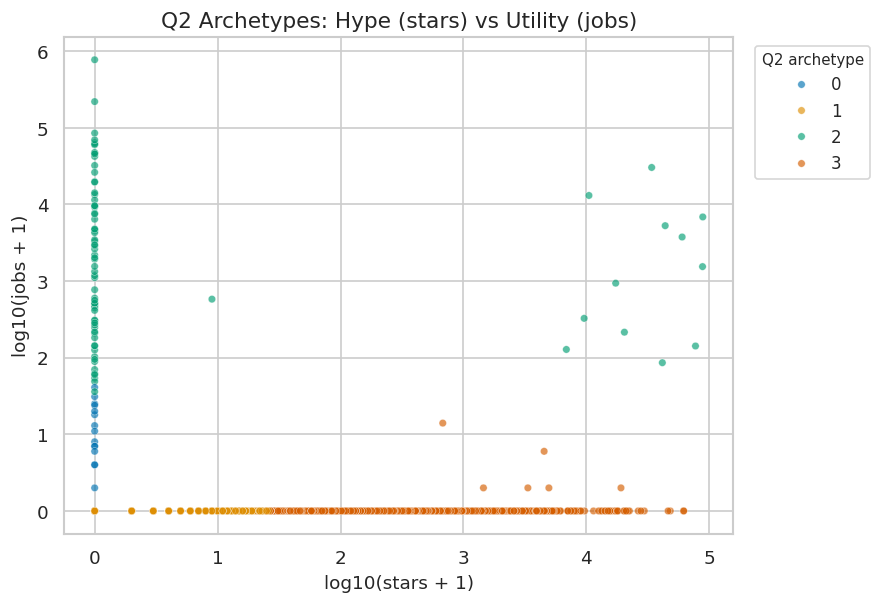

In [ ]:
# Q2 archetype visualization (keep the same lens as M2: stars vs jobs)
if {"log10_github_repo_stars","log10_number_of_jobs"}.issubset(df_hype.columns):
    plt.figure(figsize=(9.2, 5.2))
    sns.scatterplot(
        data=df_hype,
        x="log10_github_repo_stars",
        y="log10_number_of_jobs",
        hue="q2_cluster",
        palette=blue_palette(df_hype["q2_cluster"].nunique()),
        s=20,
        alpha=0.65,
        edgecolor="white", linewidth=0.3
    )
    plt.xlabel("log10(stars + 1)")
    plt.ylabel("log10(jobs + 1)")
    plt.title("Q2 Archetypes: Hype (stars) vs Utility (jobs)")
    plt.legend(title="Q2 archetype", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout(rect=[0, 0, 0.82, 1])
    plt.show()


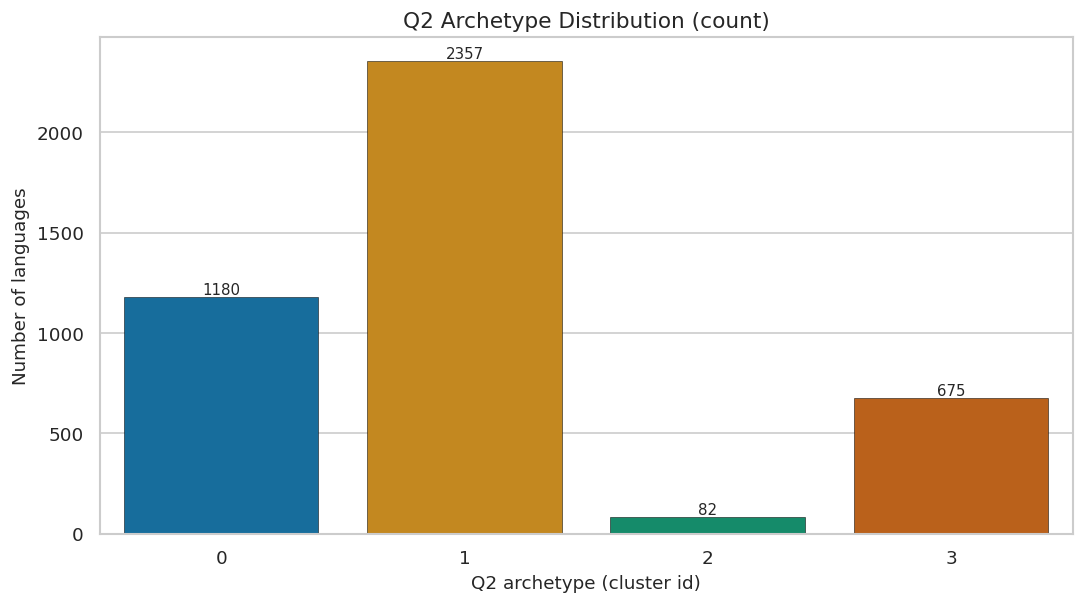

In [ ]:
# NEW BAR GRAPH (Q2): Archetype Distribution
counts = df_hype["q2_cluster"].value_counts().sort_index()
plt.figure(figsize=(9.2, 5.2))
sns.barplot(
    x=counts.index.astype(str),
    y=counts.values,
    palette=blue_palette(len(counts)), edgecolor="black", linewidth=0.3
)
plt.title("Q2 Archetype Distribution (count)")
plt.xlabel("Q2 archetype (cluster id)")
plt.ylabel("Number of languages")
for i_, v in enumerate(counts.values):
    plt.text(i_, v, str(int(v)), ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()


In [ ]:
# Q2 archetype profiles (same as M2: mean feature values by archetype)
profile_q2 = df_hype.groupby("q2_cluster")[q2_features].mean().round(3).sort_index()
display(profile_q2)


,log10_github_repo_stars,log10_wikipedia_daily_page_views,log10_number_of_users,log10_number_of_jobs
q2_cluster,,,,
0,0.011,1.562,2.387,0.013
1,0.067,0.019,0.323,0.000
2,0.667,2.908,4.757,3.266
3,2.646,0.143,2.808,0.005


## 8) Reproduce M2 Q3 (Arshdeep): Ghost languages

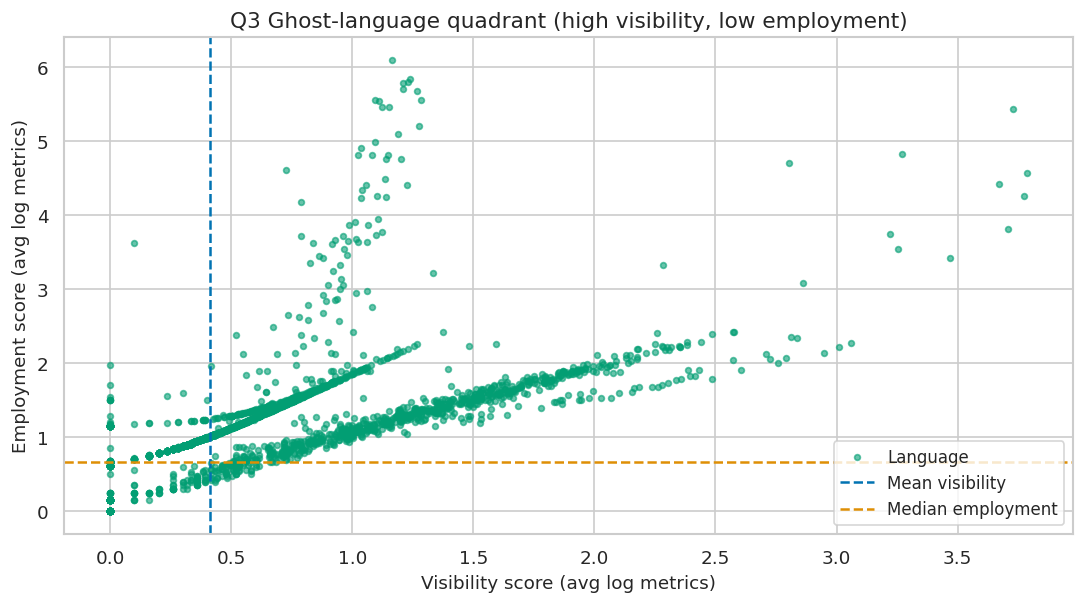

In [ ]:
# Q3 (M2 Arshdeep): Ghost languages (high visibility, low employment)
vis_cols = [c for c in ["log10_github_repo_stars","log10_wikipedia_daily_page_views","log10_github_repo_subscribers"] if c in df_hype.columns]
emp_cols = [c for c in ["log10_number_of_jobs","log10_number_of_users"] if c in df_hype.columns]

assert len(vis_cols) >= 2, f"Need at least 2 visibility cols. Found: {vis_cols}"
assert len(emp_cols) >= 1, f"Need at least 1 employment col. Found: {emp_cols}"

df_hype["visibility_score"] = df_hype[vis_cols].mean(axis=1)
df_hype["employment_score"] = df_hype[emp_cols].mean(axis=1)

x = df_hype["visibility_score"]
y = df_hype["employment_score"]
x_thr = x.mean()
y_thr = y.median()

plt.figure(figsize=(9.2, 5.2))
plt.scatter(x, y, s=12, alpha=0.6, color=PALETTE[2], label="Language")
plt.axvline(x_thr, linestyle="--", color=PALETTE[0], label="Mean visibility")
plt.axhline(y_thr, linestyle="--", color=PALETTE[1], label="Median employment")
plt.xlabel("Visibility score (avg log metrics)")
plt.ylabel("Employment score (avg log metrics)")
plt.title("Q3 Ghost-language quadrant (high visibility, low employment)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


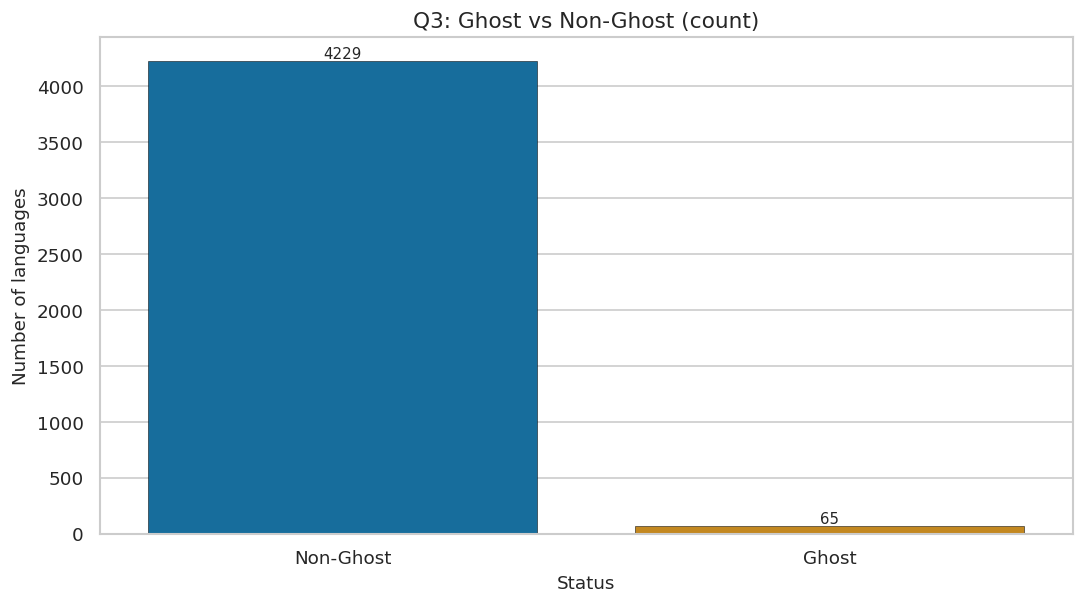

In [ ]:
# Define ghost status (same rule as M2 Q3) + NEW BAR GRAPH (Q3): Ghost vs Non-Ghost
df_hype["ghost_quadrant"] = np.where((x > x_thr) & (y < y_thr), 1, 0)

ghost_counts = df_hype["ghost_quadrant"].value_counts().reindex([0,1]).fillna(0).astype(int)
labels = ["Non-Ghost", "Ghost"]
vals = [ghost_counts.get(0,0), ghost_counts.get(1,0)]

plt.figure(figsize=(9.2, 5.2))
sns.barplot(x=labels, y=vals, palette=blue_palette(2), edgecolor="black", linewidth=0.3)
plt.title("Q3: Ghost vs Non-Ghost (count)")
plt.xlabel("Status")
plt.ylabel("Number of languages")
for i_, v in enumerate(vals):
    plt.text(i_, v, str(int(v)), ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()


### 8.1 Q3 Clustering (K-Means + Silhouette) with PCA + UMAP (M2-comparable)

We reproduce the **M2 Q3 clustering idea** (cluster languages using visibility + adoption + activity signals),
but run it on the unified `df_hype` view so the results are directly comparable with Q2 and the final M3 synergy.

**Key constraints (as requested):** K-Means + Silhouette only (no elbow), plus **PCA** and **UMAP** visualizations.


In [ ]:
# Q3 clustering features (same spirit as M2_Q3): visibility + popularity + adoption signals
# Prefer raw columns if present; otherwise fall back to unified log1p versions (keeps the concept intact).
q3_feat_map = [
    ("wikipedia_daily_page_views", "log1p_wikipedia_daily_page_views"),
    ("github_repo_stars", "log1p_github_repo_stars"),
    ("github_repo_forks", "log1p_github_repo_forks"),
    ("github_language_repos", "github_language_repos"),
    ("language_rank", "language_rank"),
    ("number_of_jobs", "log1p_number_of_jobs"),
    ("number_of_users", "log1p_number_of_users"),
]

q3_features = []
for raw, alt in q3_feat_map:
    if raw in df_hype.columns:
        q3_features.append(raw)
    elif alt in df_hype.columns:
        q3_features.append(alt)

if len(q3_features) < 4:
    raise ValueError(f"Not enough Q3 clustering features found. Found: {q3_features}")

q3_feature_df = df_hype[q3_features].copy()
# M2 used fillna(0) then scaled
q3_feature_df = q3_feature_df.apply(pd.to_numeric, errors='coerce').fillna(0)
X_q3 = StandardScaler().fit_transform(q3_feature_df)


In [ ]:
# Silhouette sweep (K-Means only) — one output table
k_list = list(range(2, 8))
rows = []
for k in k_list:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    lab = km.fit_predict(X_q3)
    s = silhouette_score(X_q3, lab)
    rows.append({"k": k, "silhouette": round(float(s), 4)})

q3_sil = pd.DataFrame(rows)
display(q3_sil)


,k,silhouette
0,2,0.9527
1,3,0.9347
2,4,0.9298
3,5,0.5223
4,6,0.5448
5,7,0.5584


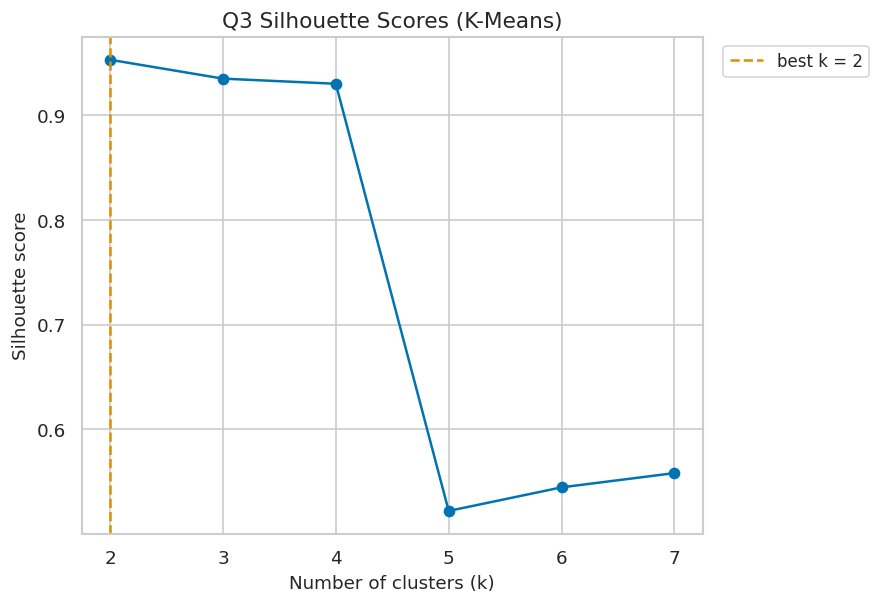

In [ ]:
# Silhouette plot (choose k with best silhouette) — one output
best_k_q3 = int(q3_sil.sort_values('silhouette', ascending=False).iloc[0]['k'])

plt.figure(figsize=(9.2, 5.2))
plt.plot(q3_sil['k'], q3_sil['silhouette'], marker='o', color=PRIMARY_COLOR)
plt.axvline(best_k_q3, linestyle='--', color=PALETTE[1], label=f"best k = {best_k_q3}")
plt.title('Q3 Silhouette Scores (K-Means)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette score')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout(rect=[0, 0, 0.82, 1])
plt.show()


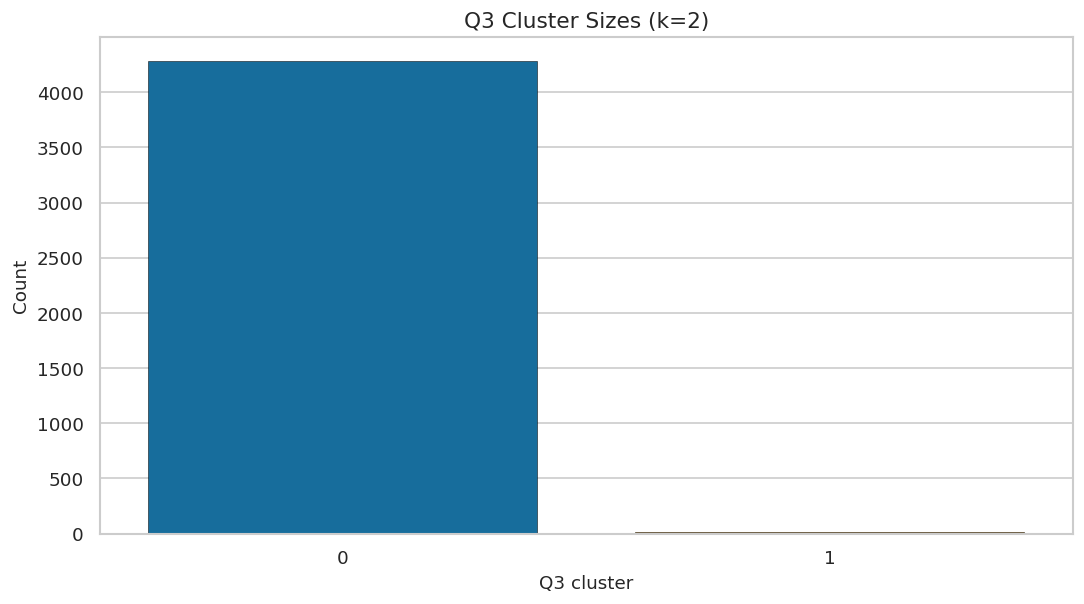

In [ ]:
# Fit final Q3 K-Means + show cluster size distribution (bar) — one output
kmeans_q3 = KMeans(n_clusters=best_k_q3, random_state=RANDOM_STATE, n_init=10)
df_hype['q3_cluster'] = kmeans_q3.fit_predict(X_q3)

counts = pd.Series(df_hype['q3_cluster']).value_counts().sort_index()
plt.figure(figsize=(9.2, 5.2))
sns.barplot(x=counts.index.astype(str), y=counts.values, palette=blue_palette(len(counts)), edgecolor='black', linewidth=0.3)
plt.title(f'Q3 Cluster Sizes (k={best_k_q3})')
plt.xlabel('Q3 cluster')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


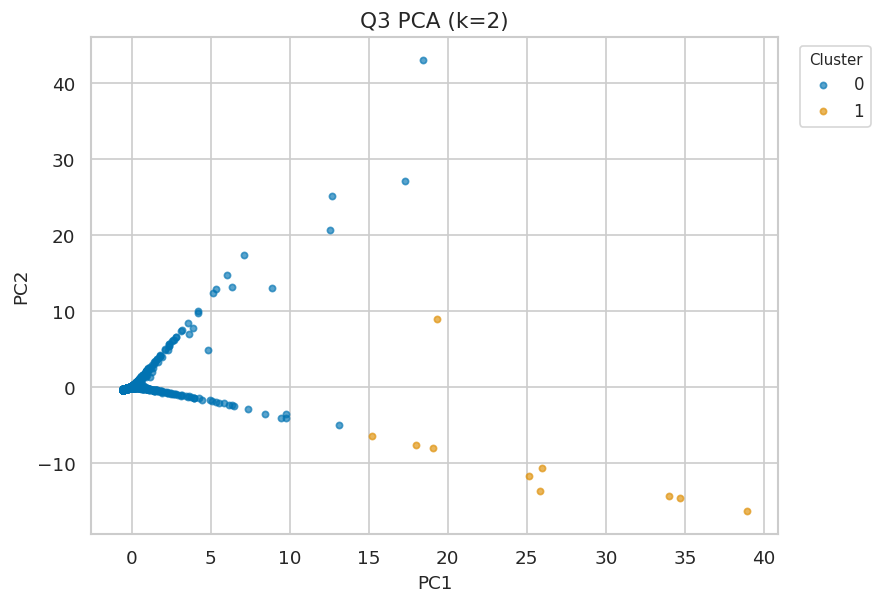

(PCA(n_components=2, random_state=42),
 array([[ 34.00361153, -14.31174826],
        [ 38.92230268, -16.24106593],
        [ 19.04078847,  -7.99986144],
        ...,
        [ -0.54387298,  -0.29134274],
        [ -0.54405273,  -0.29145136],
        [ -0.54423249,  -0.29155999]]))

In [ ]:
# Q3 PCA scatter — one output
pca_scatter(X_q3, df_hype['q3_cluster'], title=f"Q3 PCA (k={best_k_q3})")


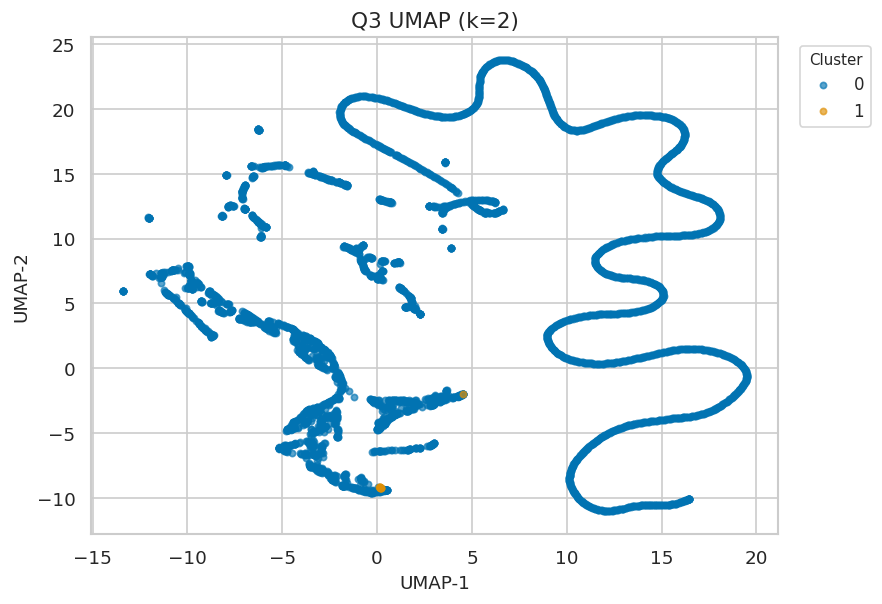

(UMAP(n_jobs=1, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}),
 array([[ 0.13341914, -9.172707  ],
        [ 0.12951909, -9.171181  ],
        [ 0.22739123, -9.240941  ],
        ...,
        [11.83966   , -5.3186946 ],
        [11.820063  , -5.336167  ],
        [11.774761  , -5.379054  ]], dtype=float32))

In [ ]:
# Q3 UMAP scatter — one output
umap_scatter(X_q3, df_hype['q3_cluster'], title=f"Q3 UMAP (k={best_k_q3})")


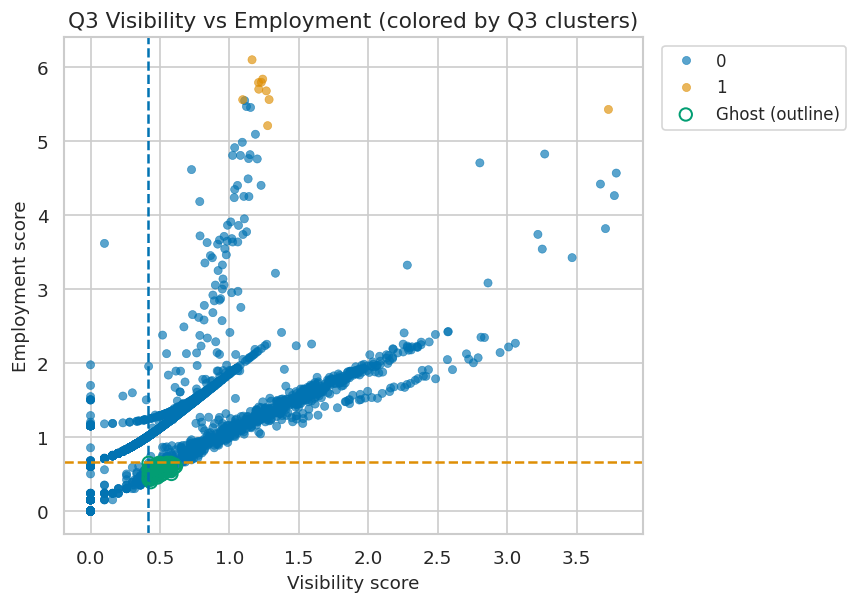

In [ ]:
# M2-style view: Visibility vs Employment colored by Q3 clusters, highlighting Ghost languages — one output
plt.figure(figsize=(9.2, 5.2))
sns.scatterplot(x=df_hype['visibility_score'], y=df_hype['employment_score'], hue=df_hype['q3_cluster'],
                palette=blue_palette(df_hype['q3_cluster'].nunique()), s=24, alpha=0.65, edgecolor=None)

# highlight ghosts
ghost_df = df_hype[df_hype['ghost_quadrant'] == 1]
plt.scatter(ghost_df['visibility_score'], ghost_df['employment_score'],
            s=55, facecolors='none', edgecolors=PALETTE[2], linewidths=1.2, label='Ghost (outline)')

plt.axvline(x_thr, linestyle='--', color=PALETTE[0])
plt.axhline(y_thr, linestyle='--', color=PALETTE[1])
plt.title('Q3 Visibility vs Employment (colored by Q3 clusters)')
plt.xlabel('Visibility score')
plt.ylabel('Employment score')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout(rect=[0, 0, 0.80, 1])
plt.show()


In [ ]:
# Q3: Ghost quadrant summary (one output)
ghost_count = int(df_hype["ghost_quadrant"].sum()) if "ghost_quadrant" in df_hype.columns else 0
ghost_summary = pd.DataFrame([{
    "ghost_quadrant_count": ghost_count,
    "total_rows_in_df_hype": int(len(df_hype)),
    "ghost_pct": round(ghost_count / max(1, len(df_hype)) * 100, 2)
}])
display(ghost_summary)


,ghost_quadrant_count,total_rows_in_df_hype,ghost_pct
0,65,4294,1.51


In [ ]:
# Q3: Example ghost languages (one output)
if "title" in df_hype.columns and {"visibility_score","employment_score","ghost_quadrant"}.issubset(df_hype.columns):
    ex = (df_hype.loc[df_hype["ghost_quadrant"]==1, ["title","visibility_score","employment_score"]]
          .sort_values("visibility_score", ascending=False)
          .head(15))
    display(ex)
else:
    display(pd.DataFrame([{"note": "Required columns not found for ghost examples."}]))


,title,visibility_score,employment_score
1859,IPL,0.615033,0.602060
2419,duro,0.604304,0.627636
2324,polymath,0.604304,0.588046
2651,Broccoli,0.582729,0.500000
2650,TextFrame,0.580121,0.539591
1779,texti,0.580121,0.556972
1195,Language Server Index Format,0.577465,0.650515
2526,ForthScript,0.569190,0.627636
2422,penguor,0.560414,0.556972
1986,h,0.551071,0.650515


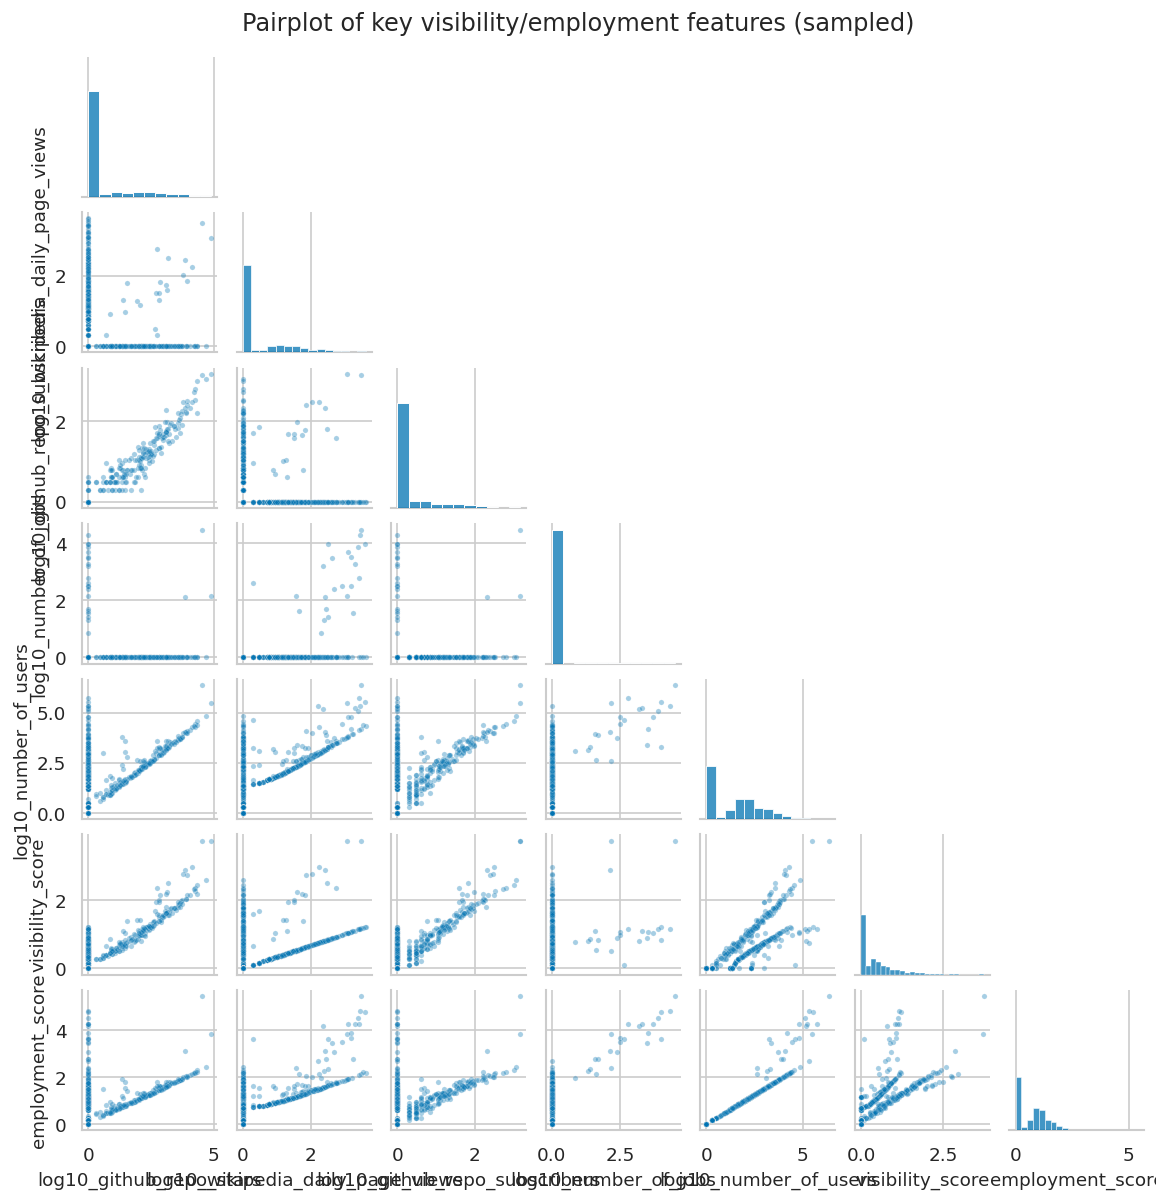

In [ ]:
# Q3 additional visual (M2 Q3 style): pairplot (sampled + compact)
pair_cols = []
for c in ["log10_github_repo_stars","log10_wikipedia_daily_page_views","log10_github_repo_subscribers",
          "log10_number_of_jobs","log10_number_of_users","visibility_score","employment_score"]:
    if c in df_hype.columns:
        pair_cols.append(c)

pair_df = df_hype[pair_cols].dropna()

# downsample for speed
if len(pair_df) > 800:
    pair_df = pair_df.sample(800, random_state=RANDOM_STATE)

if len(pair_cols) >= 4 and len(pair_df) > 50:
    sns.pairplot(pair_df, corner=True, plot_kws={"s": 10, "alpha": 0.35}, height=1.4)
    plt.suptitle("Pairplot of key visibility/employment features (sampled)", y=1.02)
    plt.show()
else:
    print("Not enough columns/rows for pairplot; skipping.")


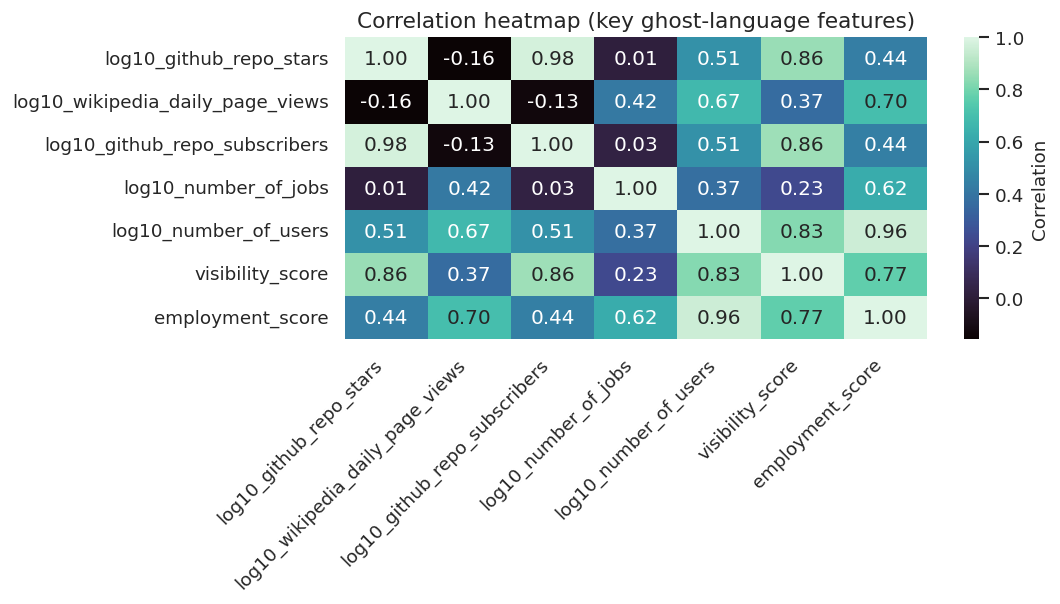

In [ ]:
# Q3 additional visual: correlation heatmap (compact + blue palette)
if len(pair_cols) >= 3 and len(pair_df) > 50:
    plt.figure(figsize=(9.2, 5.2))
    sns.heatmap(
        pair_df.corr(numeric_only=True),
        cmap=HEATMAP_CMAP,
        annot=True,
        fmt=".2f",
        cbar_kws={"label":"Correlation"}
    )
    plt.title("Correlation heatmap (key ghost-language features)")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


## 9) Reproduce M2 Q4 (Ahrar): Longevity / survival clustering

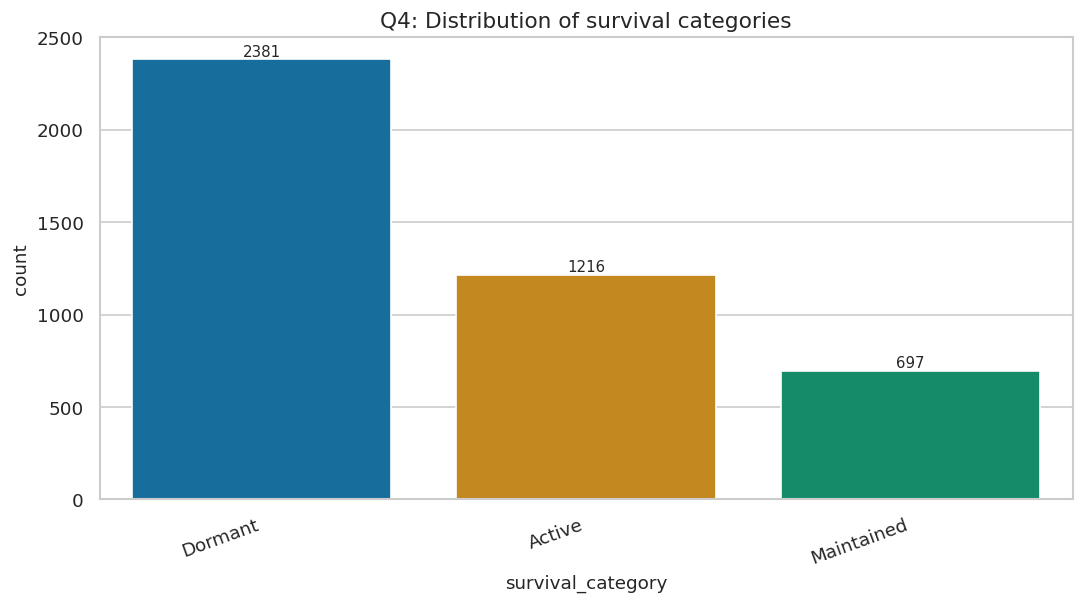

In [ ]:

# Q4 (M2 Ahrar): Longevity / survival clustering

# Survival category distribution (bar)
if "survival_category" in df_clean.columns:
    counts = df_clean["survival_category"].value_counts()
    plt.figure(figsize=(9.2, 5.2))
    sns.barplot(
        x=counts.index.astype(str),
        y=counts.values,
        palette=blue_palette(len(counts))
    )
    plt.title("Q4: Distribution of survival categories")
    plt.xlabel("survival_category")
    plt.ylabel("count")
    plt.xticks(rotation=20, ha="right")
    for i_, v in enumerate(counts.values):
        plt.text(i_, v, str(int(v)), ha="center", va="bottom", fontsize=9)
    plt.tight_layout()
    plt.show()


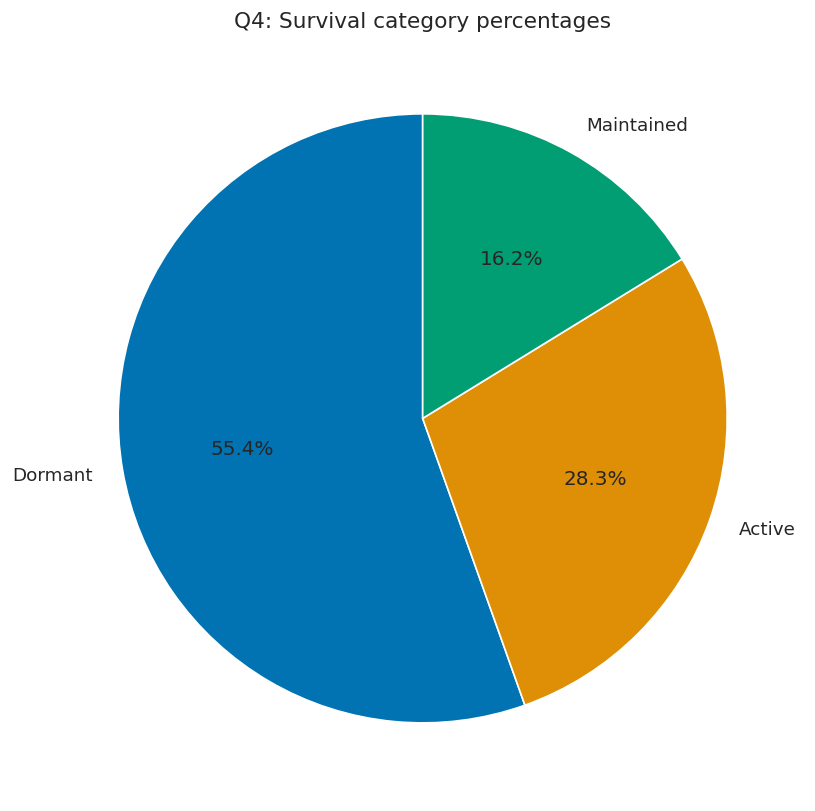

In [ ]:
# Survival category distribution (pie) — optional but kept for M2 comparability (blue shades)
if "survival_category" in df_clean.columns:
    counts = df_clean["survival_category"].value_counts()
    plt.figure(figsize=(7.0, 7.0))
    plt.pie(
        (counts / counts.sum()).values,
        labels=counts.index.astype(str),
        autopct="%1.1f%%",
        startangle=90,
        colors=blue_palette(len(counts))
    )
    plt.title("Q4: Survival category percentages")
    plt.tight_layout()
    plt.show()


,k,silhouette,inertia
0,2,0.390850,239677.390486
1,3,0.206270,231748.475618
2,4,0.210101,225299.200167
3,5,0.236984,221597.402384
4,6,0.229516,215152.955796
5,7,0.235311,211870.080614


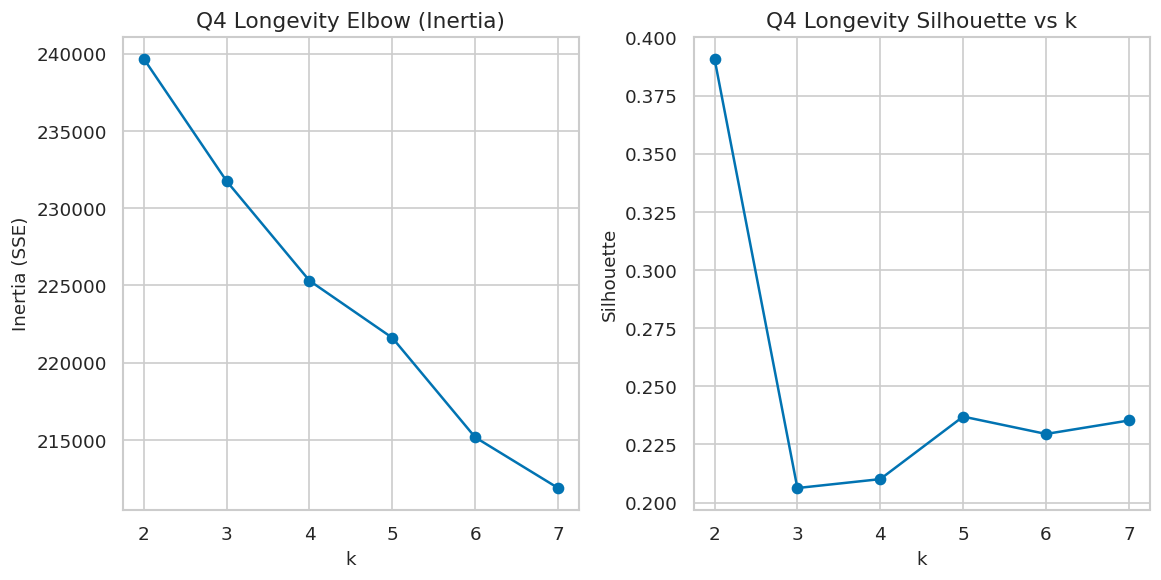

In [ ]:
# Q4 feature set + clustering evaluation (silhouette + elbow)
selected_features = [
    "type","file_type","features_has_comments","features_has_semantic_indentation","features_has_line_comments",
    "has_domain","has_github","has_wikipedia",
    "ecosystem_score","age","years_since_last_activity",
    "log1p_number_of_users","log1p_number_of_jobs","log1p_book_count","log1p_central_package_repository_count"
]
selected_features = [c for c in selected_features if c in df_long.columns]
df_q4 = df_long[selected_features].copy()

categorical_cols = [c for c in ["type","file_type","features_has_comments","features_has_semantic_indentation","features_has_line_comments"] if c in df_q4.columns]
df_q4_enc = pd.get_dummies(df_q4, columns=categorical_cols, dummy_na=True)

X_q4 = df_q4_enc.fillna(0)
X_q4_prep = pipe.fit_transform(X_q4)

scores_q4 = silhouette_sweep_kmeans(X_q4_prep, k_list)
display(scores_q4)
plot_elbow_sil(scores_q4, title_prefix="Q4 Longevity")

best_k_q4 = int(scores_q4.sort_values("silhouette", ascending=False).iloc[0]["k"])
labels_q4 = KMeans(n_clusters=best_k_q4, random_state=RANDOM_STATE, n_init=10).fit_predict(X_q4_prep)


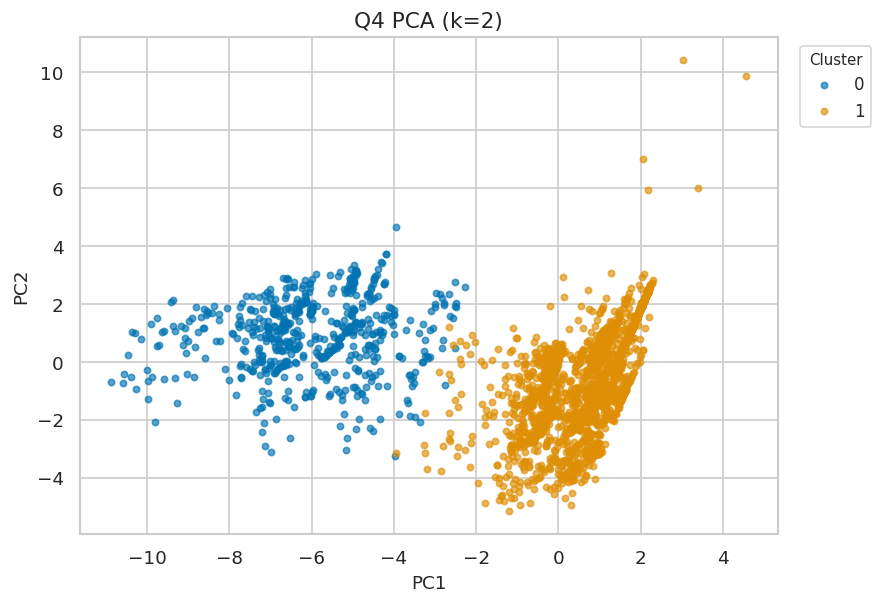

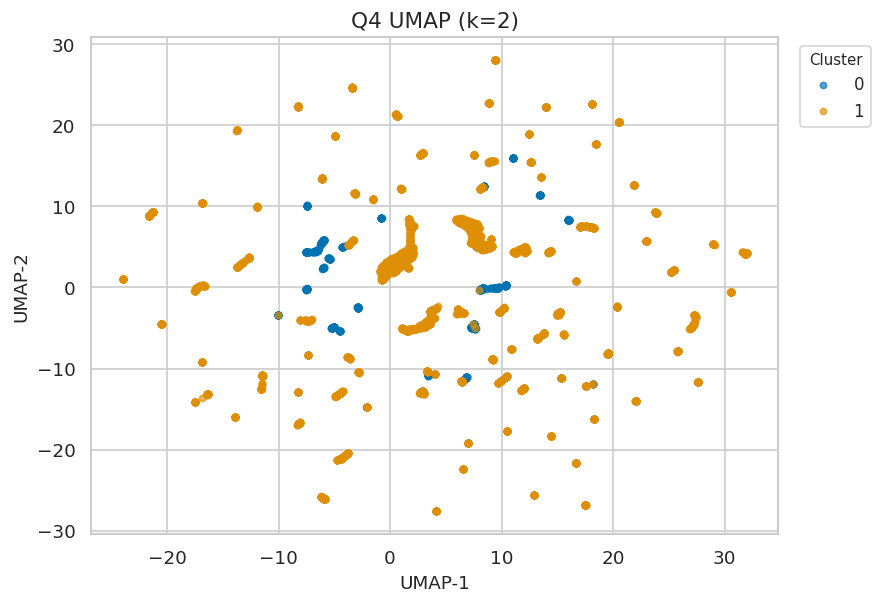

(UMAP(n_jobs=1, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}),
 array([[  8.05649   ,  -0.26275593],
        [  8.068371  ,  -0.25663498],
        [  8.084925  ,  -0.24512438],
        ...,
        [ -4.740387  , -21.304981  ],
        [-11.456974  , -10.871974  ],
        [ 18.246857  ,   7.336405  ]], dtype=float32))

In [ ]:
# Q4 embeddings (PCA + UMAP)
pca_scatter(X_q4_prep, labels_q4, title=f"Q4 PCA (k={best_k_q4})")
umap_scatter(X_q4_prep, labels_q4, title=f"Q4 UMAP (k={best_k_q4})")


In [ ]:
# Q4 cluster mix vs survival_category (table)
df_tmp = df_clean.copy()
df_tmp["q4_cluster"] = labels_q4
if "survival_category" in df_tmp.columns:
    mix = pd.crosstab(df_tmp["q4_cluster"], df_tmp["survival_category"], normalize="index").round(3)
    display(mix)


survival_category,Active,Maintained,Dormant
q4_cluster,,,
0,0.557,0.243,0.200
1,0.238,0.149,0.613


## 10) M3 Integrated Clustering (Synergy result)

In [ ]:

# M3 Integrated Clustering (Synergy result)

integrated_cols = []

integrated_cols += [c for c in [
    "log1p_github_repo_stars","log1p_wikipedia_daily_page_views",
    "log1p_number_of_users","log1p_number_of_jobs",
    "log1p_github_repo_subscribers","log1p_github_repo_forks"
] if c in df_clean.columns]

integrated_cols += [c for c in ["age","years_since_last_activity","ecosystem_score"] if c in df_clean.columns]
integrated_cols += [c for c in ["has_domain","has_github","has_wikipedia"] if c in df_clean.columns]
integrated_cols += [c for c in ["num_extensions_listed"] if c in df_clean.columns]

integrated_cols = list(dict.fromkeys(integrated_cols))

X_m3 = df_clean[integrated_cols].copy()
X_m3_prep = pipe.fit_transform(X_m3)

scores_m3 = silhouette_sweep_kmeans(X_m3_prep, k_list)


In [ ]:
# M3 integrated feature set (one output)
display(pd.DataFrame({"integrated_feature": integrated_cols}))


,integrated_feature
0,log1p_github_repo_stars
1,log1p_wikipedia_daily_page_views
2,log1p_number_of_users
3,log1p_number_of_jobs
4,log1p_github_repo_subscribers
5,log1p_github_repo_forks
6,age
7,years_since_last_activity
8,has_domain
9,has_github


In [ ]:
# M3: silhouette + inertia table (one output)
display(scores_m3)


,k,silhouette,inertia
0,2,0.464304,34540.869097
1,3,0.426113,25631.844822
2,4,0.440633,21217.553754
3,5,0.431596,17923.398140
4,6,0.429737,15639.790625
5,7,0.414357,13449.361370


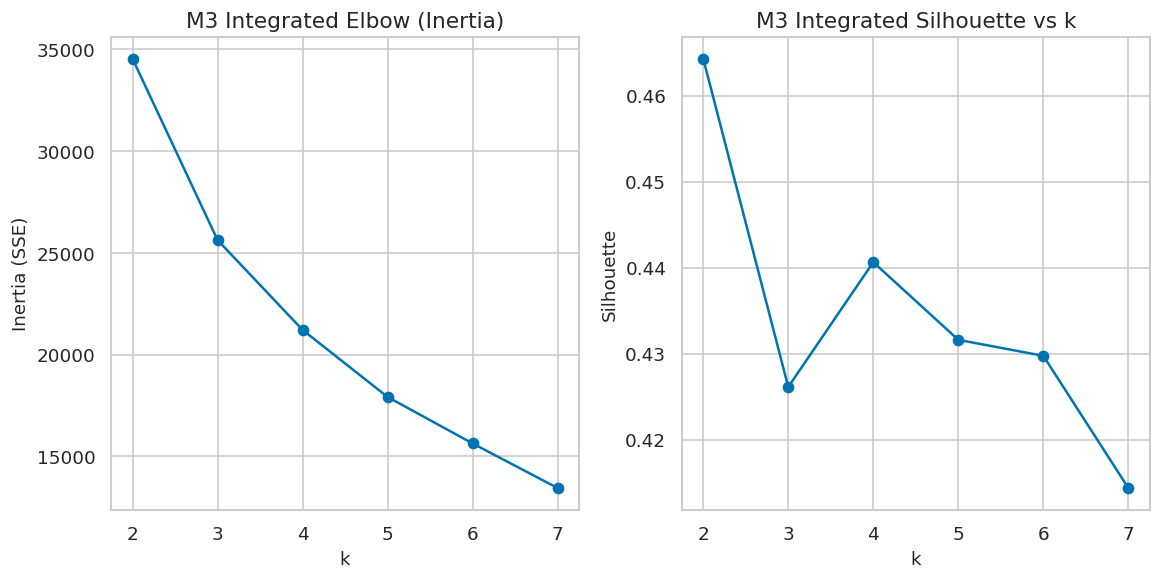

In [ ]:
# M3: elbow + silhouette plot (one output)
plot_elbow_sil(scores_m3, title_prefix="M3 Integrated")


In [ ]:
# M3: chosen k (best silhouette) — one output
best_k_m3 = int(scores_m3.sort_values("silhouette", ascending=False).iloc[0]["k"])
display(pd.DataFrame([{"chosen_k": best_k_m3}]))


,chosen_k
0,2


In [ ]:
# Fit final M3 clustering (prep; no output)
df_clean["m3_cluster"] = KMeans(n_clusters=best_k_m3, random_state=RANDOM_STATE, n_init=10).fit_predict(X_m3_prep)


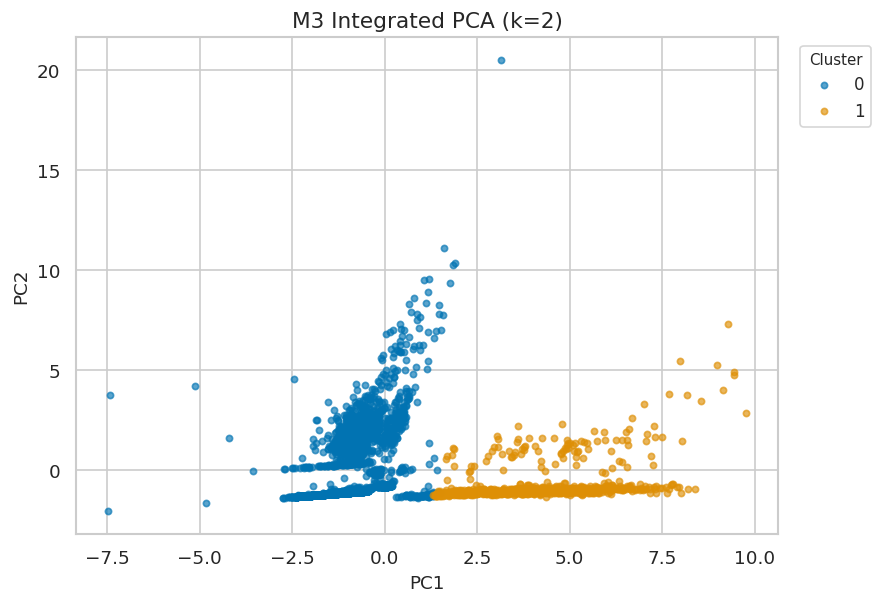

(PCA(n_components=2, random_state=42),
 array([[ 1.12576259,  8.37582884],
        [ 1.60529341, 11.12878237],
        [ 0.80498331,  8.62914111],
        ...,
        [-2.49261567, -1.32015563],
        [-1.81930321, -1.22551938],
        [-1.14599076, -1.13088314]]))

In [ ]:
# M3 embedding (PCA) — one output
pca_scatter(X_m3_prep, df_clean["m3_cluster"], title=f"M3 Integrated PCA (k={best_k_m3})")


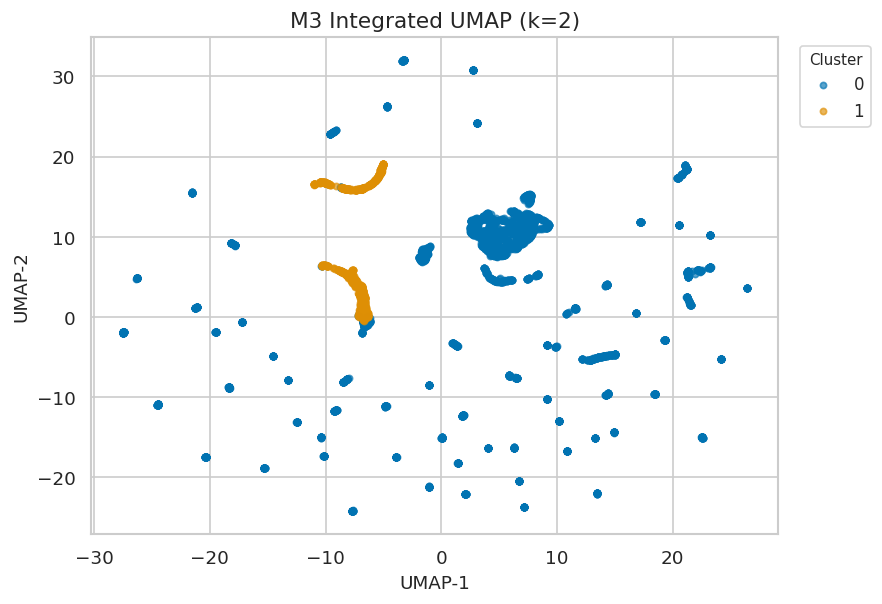

(UMAP(n_jobs=1, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}),
 array([[  7.700683 ,  15.276819 ],
        [  7.396691 ,  15.162822 ],
        [  7.6992207,  15.253983 ],
        ...,
        [ 21.078506 ,  18.854319 ],
        [ -4.8589835, -11.1734915],
        [ 10.850682 , -16.72681  ]], dtype=float32))

In [ ]:
# M3 embedding (UMAP) — one output
umap_scatter(X_m3_prep, df_clean["m3_cluster"], title=f"M3 Integrated UMAP (k={best_k_m3})")


In [ ]:
# Cluster profiles (mean feature values)
profile_m3 = df_clean.groupby("m3_cluster")[integrated_cols].mean().round(3).sort_index()
display(profile_m3)


,log1p_github_repo_stars,log1p_wikipedia_daily_page_views,log1p_number_of_users,log1p_number_of_jobs,log1p_github_repo_subscribers,log1p_github_repo_forks,age,years_since_last_activity,has_domain,has_github,has_wikipedia,num_extensions_listed
m3_cluster,,,,,,,,,,,,
0,0.022,1.381,2.471,0.161,0.017,0.002,31.607,23.721,0.112,0.024,0.422,0.296
1,5.572,0.389,6.007,0.121,2.929,3.248,9.054,1.540,0.398,1.000,0.120,0.261


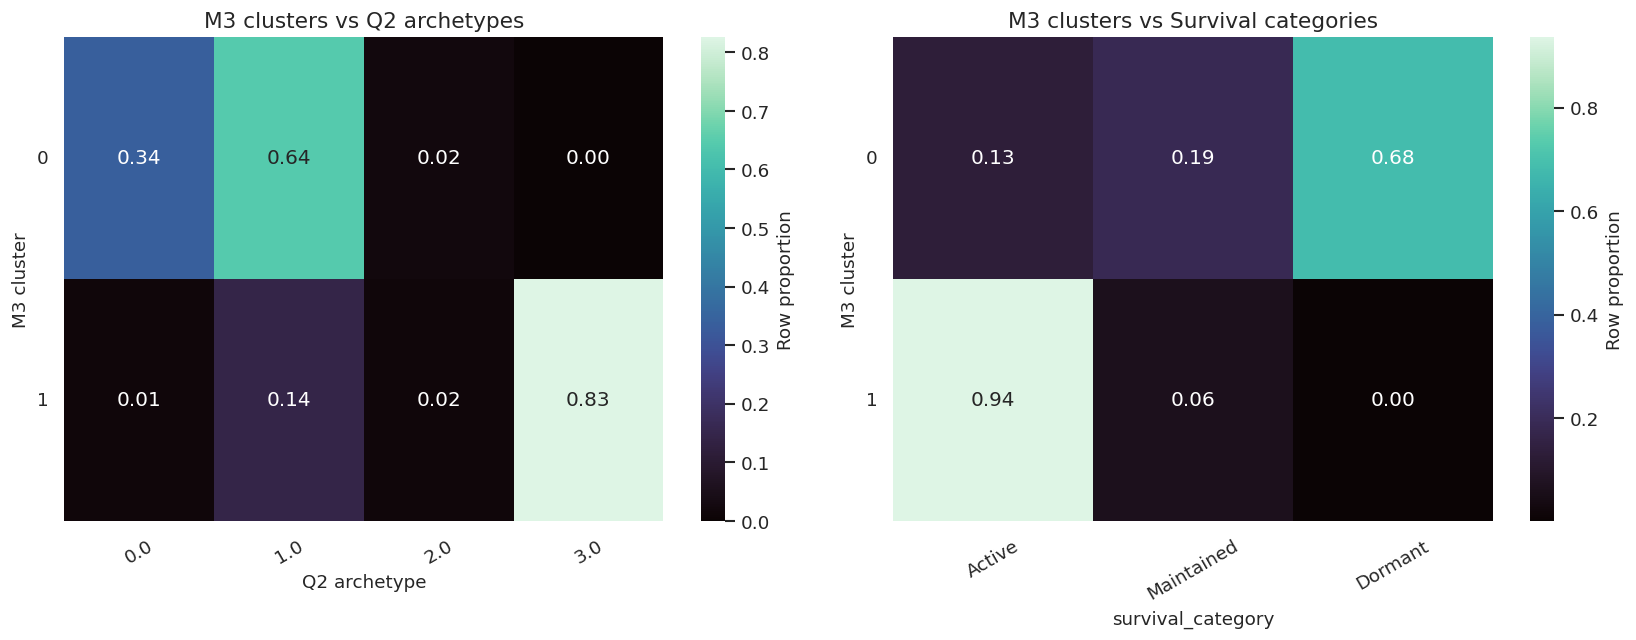

In [ ]:
# Bring in Q2 archetypes + Q3 ghost flag for synergy comparisons
# (Keeps original M2 definitions; we only merge them into one table.)
if "q2_cluster" in df_hype.columns:
    df_clean.loc[df_hype.index, "q2_cluster"] = df_hype["q2_cluster"]
if "ghost_quadrant" in df_hype.columns:
    df_clean.loc[df_hype.index, "ghost_quadrant"] = df_hype["ghost_quadrant"]

# Human-readable ghost status
if "ghost_quadrant" in df_clean.columns:
    df_clean["ghost_status"] = df_clean["ghost_quadrant"].map({0:"Non-Ghost", 1:"Ghost"})

# Crosstabs (used below in annotated heatmaps)
ctab = None
ctab2 = None
if "q2_cluster" in df_clean.columns:
    ctab = pd.crosstab(df_clean["m3_cluster"], df_clean["q2_cluster"], normalize="index").round(3)

if "survival_category" in df_clean.columns:
    ctab2 = pd.crosstab(df_clean["m3_cluster"], df_clean["survival_category"], normalize="index").round(3)

# Compact comparison figure (keeps notebook clean)
n_plots = int(ctab is not None) + int(ctab2 is not None)
if n_plots > 0:
    fig_w = 14 if n_plots == 2 else 10
    fig, axes = plt.subplots(1, n_plots, figsize=(fig_w, 5.5))
    if n_plots == 1:
        axes = [axes]

    ax_i = 0
    if ctab is not None:
        sns.heatmap(ctab, annot=True, fmt=".2f", cmap=HEATMAP_CMAP,
                    cbar_kws={"label":"Row proportion"}, ax=axes[ax_i])
        axes[ax_i].set_title("M3 clusters vs Q2 archetypes")
        axes[ax_i].set_xlabel("Q2 archetype")
        axes[ax_i].set_ylabel("M3 cluster")
        axes[ax_i].tick_params(axis="x", rotation=30)
        axes[ax_i].tick_params(axis="y", rotation=0)
        axes[ax_i].tick_params(axis="x", rotation=30)
        axes[ax_i].tick_params(axis="y", rotation=0)
        ax_i += 1

    if ctab2 is not None:
        sns.heatmap(ctab2, annot=True, fmt=".2f", cmap=HEATMAP_CMAP,
                    cbar_kws={"label":"Row proportion"}, ax=axes[ax_i])
        axes[ax_i].set_title("M3 clusters vs Survival categories")
        axes[ax_i].set_xlabel("survival_category")
        axes[ax_i].set_ylabel("M3 cluster")
        axes[ax_i].tick_params(axis="x", rotation=30)
        axes[ax_i].tick_params(axis="y", rotation=0)
        axes[ax_i].tick_params(axis="x", rotation=30)
        axes[ax_i].tick_params(axis="y", rotation=0)

    plt.tight_layout()
    plt.show()
else:
    print("Missing required columns for synergy crosstabs; skipping.")


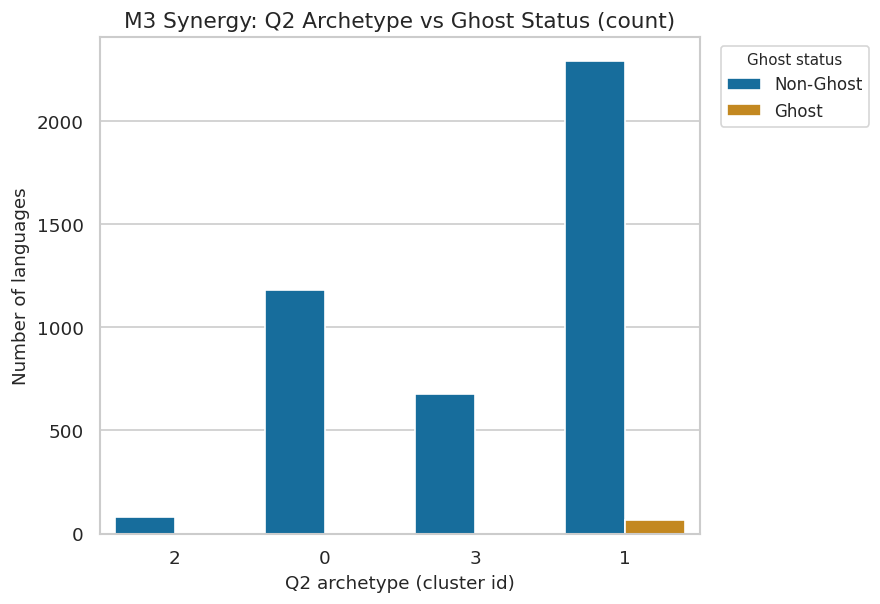

In [ ]:
# NEW BAR GRAPH (M3 synergy): Archetype vs Ghost Status
if {"q2_cluster","ghost_status"}.issubset(df_clean.columns):
    tmp = df_clean.dropna(subset=["q2_cluster","ghost_status"]).copy()
    tmp["q2_cluster"] = tmp["q2_cluster"].astype(int).astype(str)

    ghost_status_order = ["Non-Ghost", "Ghost"]
    ghost_status_pal = {k: PALETTE[i % len(PALETTE)] for i, k in enumerate(ghost_status_order)}

    plt.figure(figsize=(9.2, 5.2))
    sns.countplot(
        data=tmp,
        x="q2_cluster",
        hue="ghost_status",
        hue_order=ghost_status_order,
        palette=ghost_status_pal
    )
    plt.title("M3 Synergy: Q2 Archetype vs Ghost Status (count)")
    plt.xlabel("Q2 archetype (cluster id)")
    plt.ylabel("Number of languages")
    plt.legend(title="Ghost status", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout(rect=[0, 0, 0.82, 1])
    plt.show()


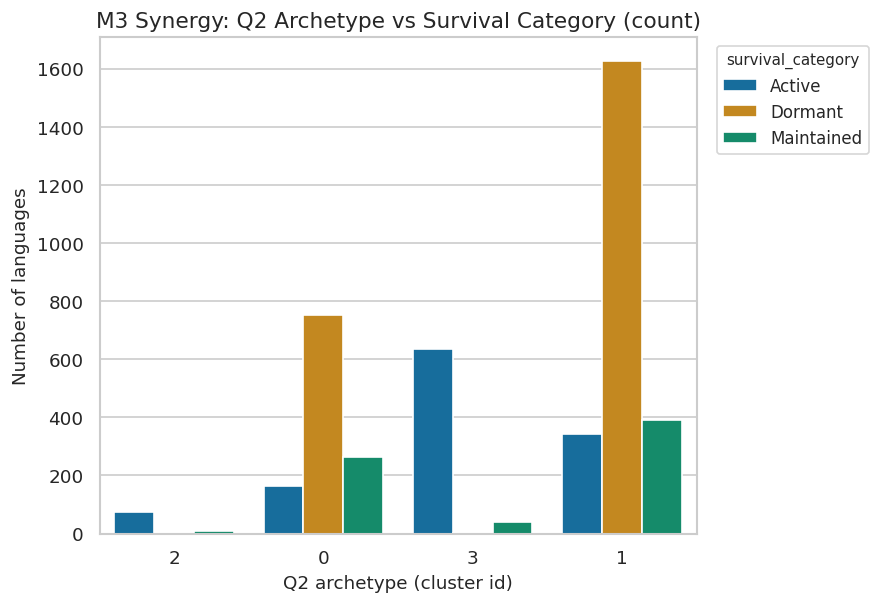

In [ ]:
# NEW BAR GRAPH (M3 synergy): Archetype vs Survival
if {"q2_cluster","survival_category"}.issubset(df_clean.columns):
    tmp = df_clean.dropna(subset=["q2_cluster","survival_category"]).copy()
    tmp["q2_cluster"] = tmp["q2_cluster"].astype(int).astype(str)

    survival_order = sorted(tmp["survival_category"].unique())
    survival_pal = {k: PALETTE[i % len(PALETTE)] for i, k in enumerate(survival_order)}

    plt.figure(figsize=(9.2, 5.2))
    sns.countplot(
        data=tmp,
        x="q2_cluster",
        hue="survival_category",
        hue_order=survival_order,
        palette=survival_pal
    )
    plt.title("M3 Synergy: Q2 Archetype vs Survival Category (count)")
    plt.xlabel("Q2 archetype (cluster id)")
    plt.ylabel("Number of languages")
    plt.legend(title="survival_category", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout(rect=[0, 0, 0.82, 1])
    plt.show()


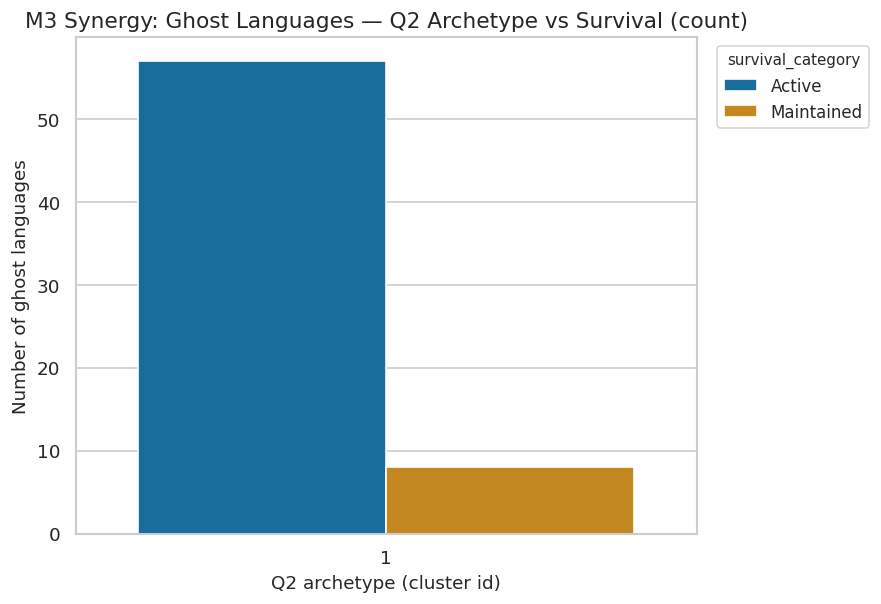

In [ ]:
# NEW BAR GRAPH (M3 synergy): Ghost languages — Archetype vs Survival
if {"q2_cluster","survival_category","ghost_status"}.issubset(df_clean.columns):
    tmp = df_clean.dropna(subset=["q2_cluster","survival_category","ghost_status"]).copy()
    tmp = tmp[tmp["ghost_status"]=="Ghost"]
    if len(tmp) > 0:
        tmp["q2_cluster"] = tmp["q2_cluster"].astype(int).astype(str)

        survival_order = sorted(tmp["survival_category"].unique())
        survival_pal = {k: PALETTE[i % len(PALETTE)] for i, k in enumerate(survival_order)}

        plt.figure(figsize=(9.2, 5.2))
        sns.countplot(
            data=tmp,
            x="q2_cluster",
            hue="survival_category",
            hue_order=survival_order,
            palette=survival_pal
        )
        plt.title("M3 Synergy: Ghost Languages — Q2 Archetype vs Survival (count)")
        plt.xlabel("Q2 archetype (cluster id)")
        plt.ylabel("Number of ghost languages")
        plt.legend(title="survival_category", bbox_to_anchor=(1.02, 1), loc="upper left")
        plt.tight_layout(rect=[0, 0, 0.82, 1])
        plt.show()
    else:
        print("No ghost languages found after filtering; skipping plot.")


In [ ]:
# Examples per M3 cluster (single table; one output)
if "title" in df_clean.columns and "m3_cluster" in df_clean.columns:
    ex = df_clean.copy()
    score_cols = [c for c in ["github_repo_stars","number_of_jobs","wikipedia_daily_page_views"] if c in ex.columns]
    if score_cols:
        ex["_score"] = ex[score_cols].fillna(0).sum(axis=1)
    else:
        ex["_score"] = 0

    ex = ex.sort_values(["m3_cluster","_score"], ascending=[True, False])
    top_examples = ex.groupby("m3_cluster").head(10)[["m3_cluster","title"] + score_cols].reset_index(drop=True)
    display(top_examples)
else:
    display(pd.DataFrame([{"note": "Required columns not found for cluster examples."}]))


,m3_cluster,title,github_repo_stars,number_of_jobs,wikipedia_daily_page_views
0,0,HTTP,NaN,771996,6702.0
1,0,SQL,NaN,219617,3084.0
2,0,Java,NaN,85206,5242.0
3,0,HTML,NaN,69531,4897.0
4,0,JavaScript,NaN,63993,4264.0
5,0,C,NaN,59919,6268.0
6,0,C++,NaN,61098,4307.0
7,0,Python,NaN,46976,7204.0
8,0,MySQL,NaN,47466,2139.0
9,0,CSS,NaN,45617,1937.0
